# Figures for GoM trend manuscript

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import linregress
import jo_regress

## Load in data for trends
- Concat historical + SP585
- Slice to desired time period and study region (GoM)
- Calculate and add windstress curl to `ds`

In [32]:
hist = xr.open_mfdataset('/work5/stb/ESM4/historical_1850-2014/ocean_daily_cmip.*.*.nc', 
                  chunks={}, decode_timedelta=True)

In [35]:
hist_gom = hist.sel(time=slice('1993', None)).sel(xh=slice(-98.25,-80), yh=slice(17,31.5))

In [39]:
hist_gom.sos.to_netcdf('/work5/stb/ESM4/historical_1850-2014/ocean_gom/sos.nc')

In [ ]:
hist_gom.tos.to_netcdf('/work5/stb/ESM4/historical_1850-2014/ocean_gom/tos.nc')

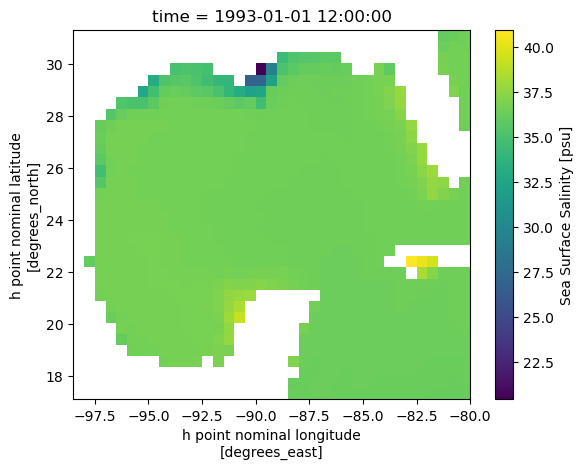

In [36]:
hist_gom.sos[0].plot()

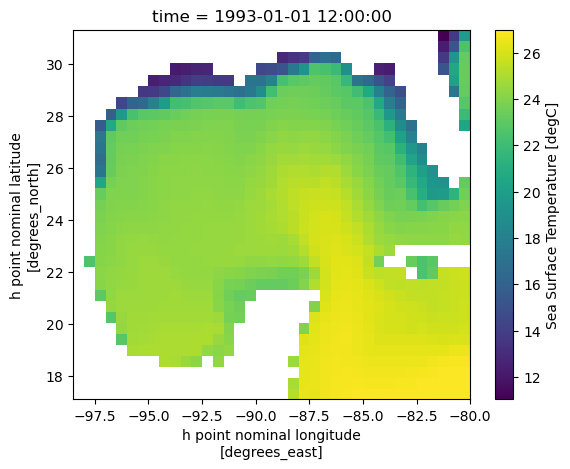

In [37]:
hist_gom.tos[0].plot()

In [3]:
atm_historical_ds = xr.open_mfdataset('/work5/stb/ESM4/historical_1850-2014/atm_gom/*.nc', 
                                  chunks={}, compat='override')
atm_sp585_ds = xr.open_mfdataset('/work5/stb/ESM4/SP585/atm_gom/*.nc',
                             chunks={}, compat='override')

In [4]:
historical_ds

<xarray.Dataset> Size: 100MB
Dimensions:  (lat: 15, lon: 16, time: 8031)
Coordinates:
  * lat      (lat) float64 120B 17.5 18.5 19.5 20.5 21.5 ... 28.5 29.5 30.5 31.5
  * lon      (lon) float64 128B 261.9 263.1 264.4 265.6 ... 278.1 279.4 280.6
  * time     (time) object 64kB 1993-01-01 00:00:00 ... 2015-01-01 00:00:00
    height   float64 8B ...
Data variables: (12/13)
    clt      (time, lat, lon) float32 8MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    hfls     (time, lat, lon) float32 8MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    hfss     (time, lat, lon) float32 8MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    huss     (time, lat, lon) float32 8MB dask.array<chunksize=(8031, 15, 16), meta=np.ndarray>
    rlds     (time, lat, lon) float32 8MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    rlus     (time, lat, lon) float32 8MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    ...       ...
    rsus     (time, lat, lon) float32 8MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    tas      (time, lat, lon) float32 8MB dask.array<chunksize=(8031, 15, 16), meta=np.ndarray>
    tauu     (time, lat, lon) float32 8MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    tauv     (time, lat, lon) float32 8MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    uas      (time, lat, lon) float32 8MB dask.array<chunksize=(8031, 15, 16), meta=np.ndarray>
    vas      (time, lat, lon) float32 8MB dask.array<chunksize=(8031, 15, 16), meta=np.ndarray>

In [5]:
sp585_ds

<xarray.Dataset> Size: 17MB
Dimensions:  (lat: 15, lon: 16, time: 1641)
Coordinates:
  * lat      (lat) float64 120B 17.5 18.5 19.5 20.5 21.5 ... 28.5 29.5 30.5 31.5
  * lon      (lon) float64 128B 261.9 263.1 264.4 265.6 ... 278.1 279.4 280.6
  * time     (time) object 13kB 2017-01-01 12:00:00 ... 2021-06-30 12:00:00
    height   float64 8B ...
Data variables:
    clt      (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>
    hfls     (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>
    hfss     (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>
    huss     (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>
    rls      (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>
    rss      (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>
    tas      (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>
    tauu     (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>
    tauv     (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>
    uas      (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>
    vas      (time, lat, lon) float32 2MB dask.array<chunksize=(1641, 15, 16), meta=np.ndarray>

In [6]:
rls = historical_ds.rlds - historical_ds.rlus
rss = historical_ds.rsds - historical_ds.rsus
historical_ds['rls'] = rls.assign_attrs({'long_name': 'Surface Net Longwave Radiation', 
                                          'units': 'W m-2', 'cell_methods': 'time: mean',
                                          'cell_measures':'area: area', 
                                          'time_avg_info':'average_T1,average_T2,average_DT',
                                          'standard_name':'surface_net_longwave_flux_in_air',
                                          'interp_method':'conserve_order2'})
historical_ds['rss'] = rss.assign_attrs({'long_name': 'Surface Net Shortwave Radiation', 
                                          'units': 'W m-2', 'cell_methods': 'time: mean',
                                          'cell_measures':'area: area', 
                                          'time_avg_info':'average_T1,average_T2,average_DT',
                                          'standard_name':'surface_net_longwave_flux_in_air',
                                          'interp_method':'conserve_order2'})
ds_historical = historical_ds.drop_vars(['rlds', 'rlus', 'rsds', 'rsus', 'height'])
ds_sp585 = sp585_ds.drop_vars('height')

ds = xr.concat([ds_historical, ds_sp585], dim='time')

$$
Curl(\tau) = \frac{\partial \tau_y}{\partial x} - \frac{\partial \tau_x}{\partial y}
$$

In [8]:
dtauvdx = ds.tauv.diff('lon') / ds.lon.diff('lon')
dtauudy = ds.tauu.diff('lat') / ds.lat.diff('lat')
wsc = dtauvdx - dtauudy

In [9]:
ds['wsc'] = wsc.assign_attrs({'long_name': 'Windstress Curl', 
                              'units': 'Pa m-1', 'cell_methods': 'time: mean',
                              'cell_measures':'area: area', 
                              'time_avg_info':'average_T1,average_T2,average_DT',
                              'standard_name':'surface_net_longwave_flux_in_air',
                              'interp_method':'conserve_order2'})

In [10]:
ds

<xarray.Dataset> Size: 121MB
Dimensions:  (lat: 15, lon: 16, time: 9672)
Coordinates:
  * lat      (lat) float64 120B 17.5 18.5 19.5 20.5 21.5 ... 28.5 29.5 30.5 31.5
  * lon      (lon) float64 128B 261.9 263.1 264.4 265.6 ... 278.1 279.4 280.6
  * time     (time) object 77kB 1993-01-01 00:00:00 ... 2021-06-30 12:00:00
Data variables:
    clt      (time, lat, lon) float32 9MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    hfls     (time, lat, lon) float32 9MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    hfss     (time, lat, lon) float32 9MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    huss     (time, lat, lon) float32 9MB dask.array<chunksize=(8031, 15, 16), meta=np.ndarray>
    tas      (time, lat, lon) float32 9MB dask.array<chunksize=(8031, 15, 16), meta=np.ndarray>
    tauu     (time, lat, lon) float32 9MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    tauv     (time, lat, lon) float32 9MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    uas      (time, lat, lon) float32 9MB dask.array<chunksize=(8031, 15, 16), meta=np.ndarray>
    vas      (time, lat, lon) float32 9MB dask.array<chunksize=(8031, 15, 16), meta=np.ndarray>
    rls      (time, lat, lon) float32 9MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    rss      (time, lat, lon) float32 9MB dask.array<chunksize=(8030, 15, 16), meta=np.ndarray>
    wsc      (time, lat, lon) float64 19MB dask.array<chunksize=(8030, 14, 15), meta=np.ndarray>

### Load in PIC (any 20yr chunk)
also download vars from SP5 run

In [ ]:
%%timeit
#to get rid of repeated warning message have to specify timedelta and time coders
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
time_delta_coder = xr.coders.CFTimedeltaCoder(decode_via_units=True)
atm_pic_ds = xr.open_mfdataset('/work5/stb/ESM4/PIC/atm/atmos_cmip.*.clt.nc', chunks={},
                               decode_times=time_coder,
                               decode_timedelta=time_delta_coder)

In [ ]:
atm_pic_ds

In [4]:
atm_pic_ds.clt

<xarray.DataArray 'clt' (time: 14600, lat: 180, lon: 288)> Size: 3GB
dask.array<open_dataset-clt, shape=(14600, 180, 288), dtype=float32, chunksize=(14600, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time     (time) object 117kB 0001-01-01 01:30:00 ... 0005-12-31 22:30:00
Attributes:
    long_name:      Total Cloud Cover Percentage
    units:          %
    cell_methods:   time: mean
    cell_measures:  area: area
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  cloud_area_fraction
    interp_method:  conserve_order1

In [ ]:
gom = dict(lon=slice(261, 281), lat=slice(17.5, 32))
da = atm_pic_ds.clt.sel(time=slice('1993', None)).resample(time='D').mean().sel(**gom)

In [ ]:
da

In [116]:
da.to_netcdf('/work/Shanice.Bailey/ESM4/PIC/atm_gom/clt.nc')

---------------------------------------------------

---------------------------------------------------

---------------------------------------------------

---------------------------------------------------

## Plot time average of the fields

In [22]:
def plot_mean(da, cmap_choice, cbar_label, var_name, var_title, quiver=True, ocean=None):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    if ocean==True:
        im = ax.pcolormesh(da.xh, da.yh, da.mean('time'), transform=ccrs.PlateCarree(), cmap=cmap_choice)
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        plt.title(f'Time-averaged {var_name} (1993-2021)', fontsize=20)
        plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/ESM4/time-mean/time-mean_{var_title}.pdf');
    else:
        im = ax.pcolormesh(da.lon, da.lat, da.mean('time'), transform=ccrs.PlateCarree(), cmap=cmap_choice)
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        plt.title(f'Time-averaged {var_name} (1993-2021)', fontsize=20)
        plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/ESM4/time-mean/time-mean_{var_title}.pdf');        

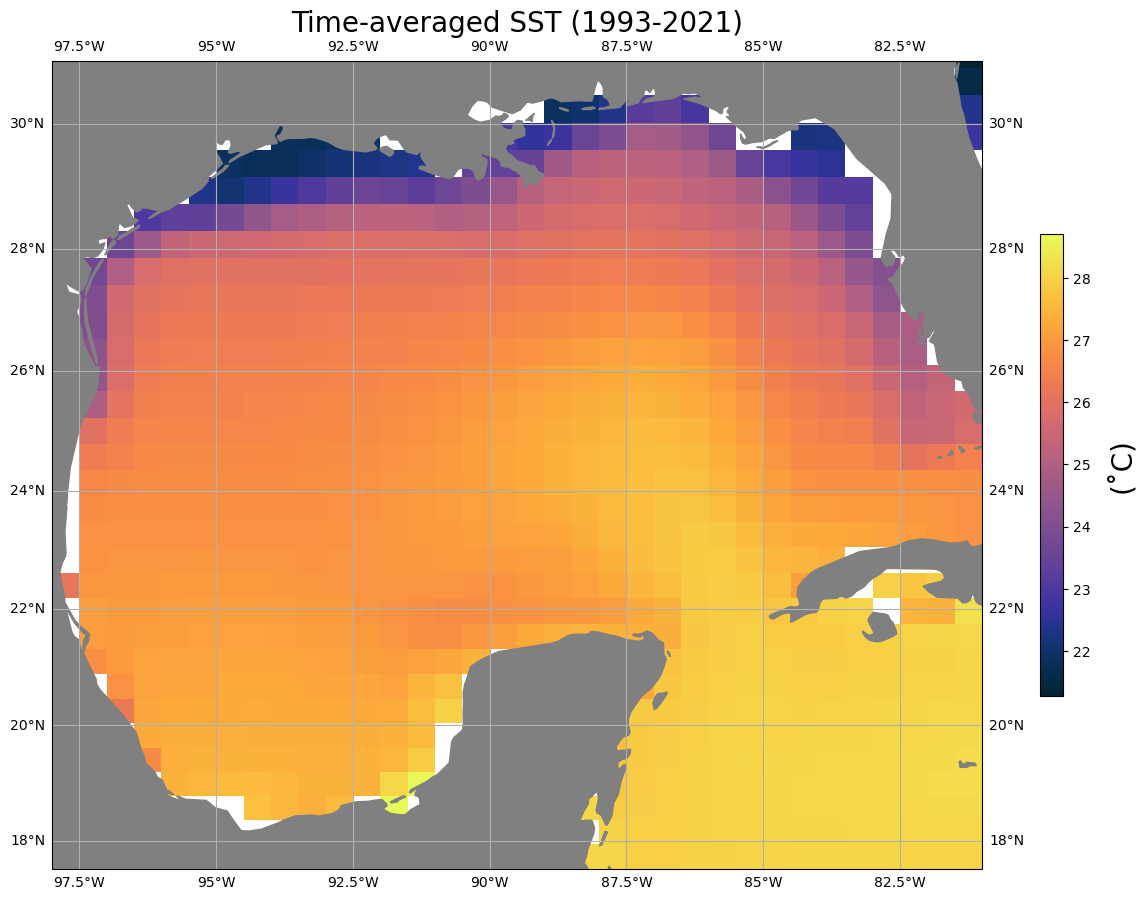

In [19]:
plot_mean(sst, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_name='SST', var_title='sst', ocean=True)

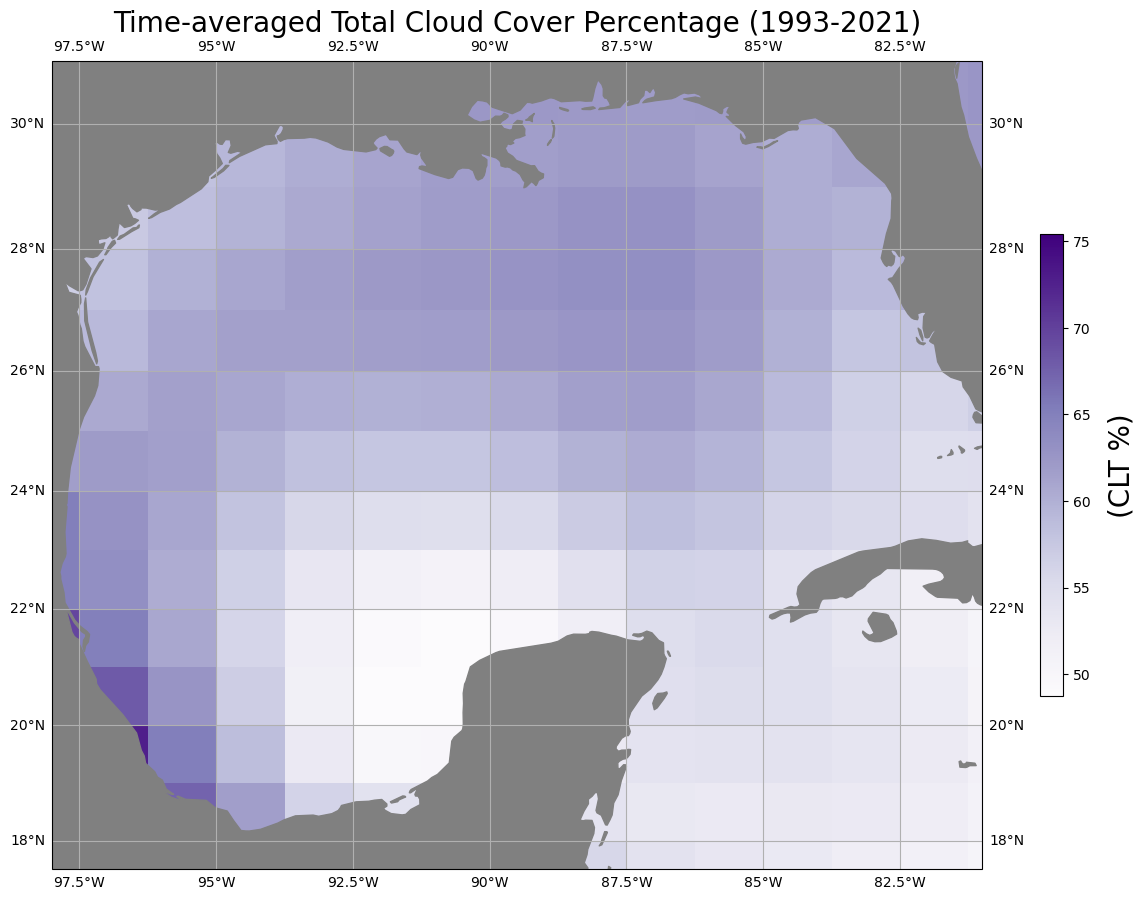

In [16]:
plot_mean(ds.clt, cmap_choice='Purples', cbar_label='(CLT %)', 
          var_name='Total Cloud Cover Percentage', var_title='clt')

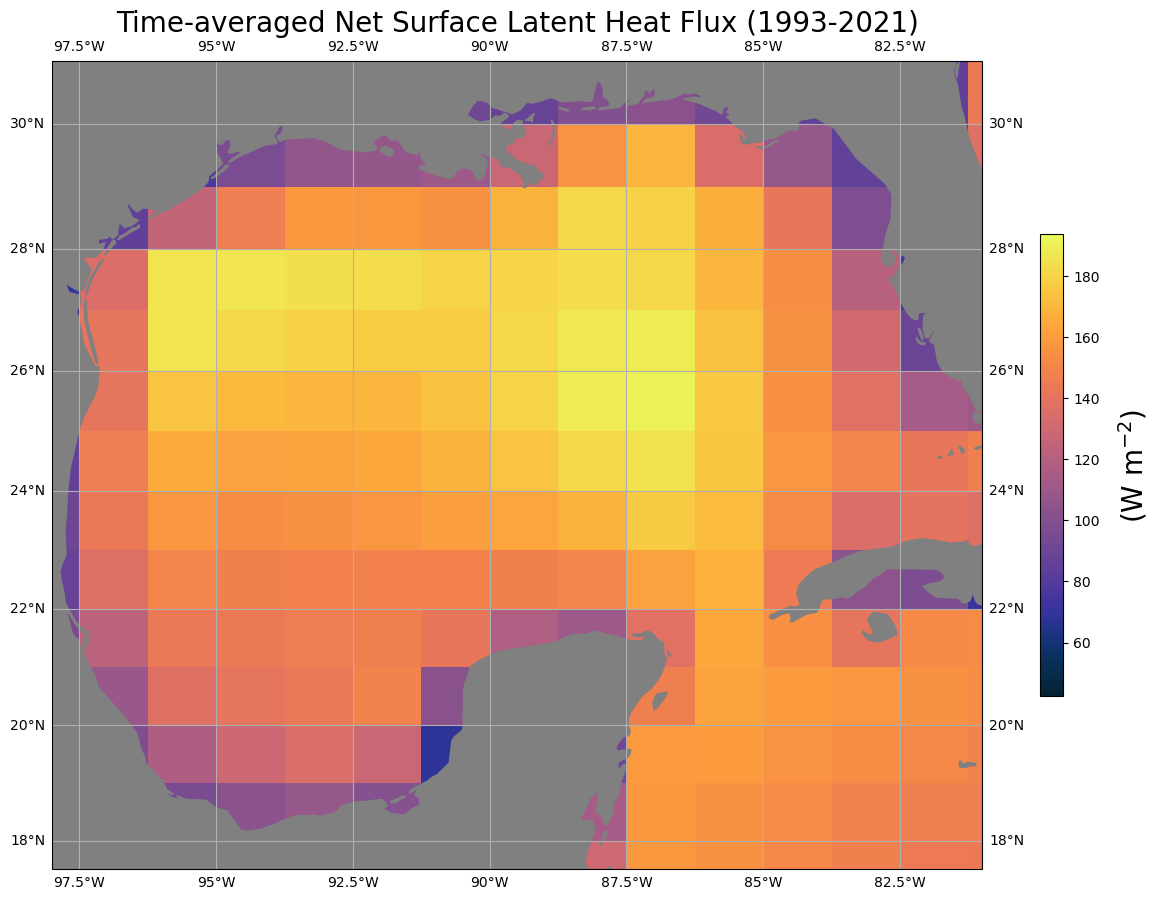

In [15]:
plot_mean(ds.hfls, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)', 
          var_name='Net Surface Latent Heat Flux', var_title='hfls')

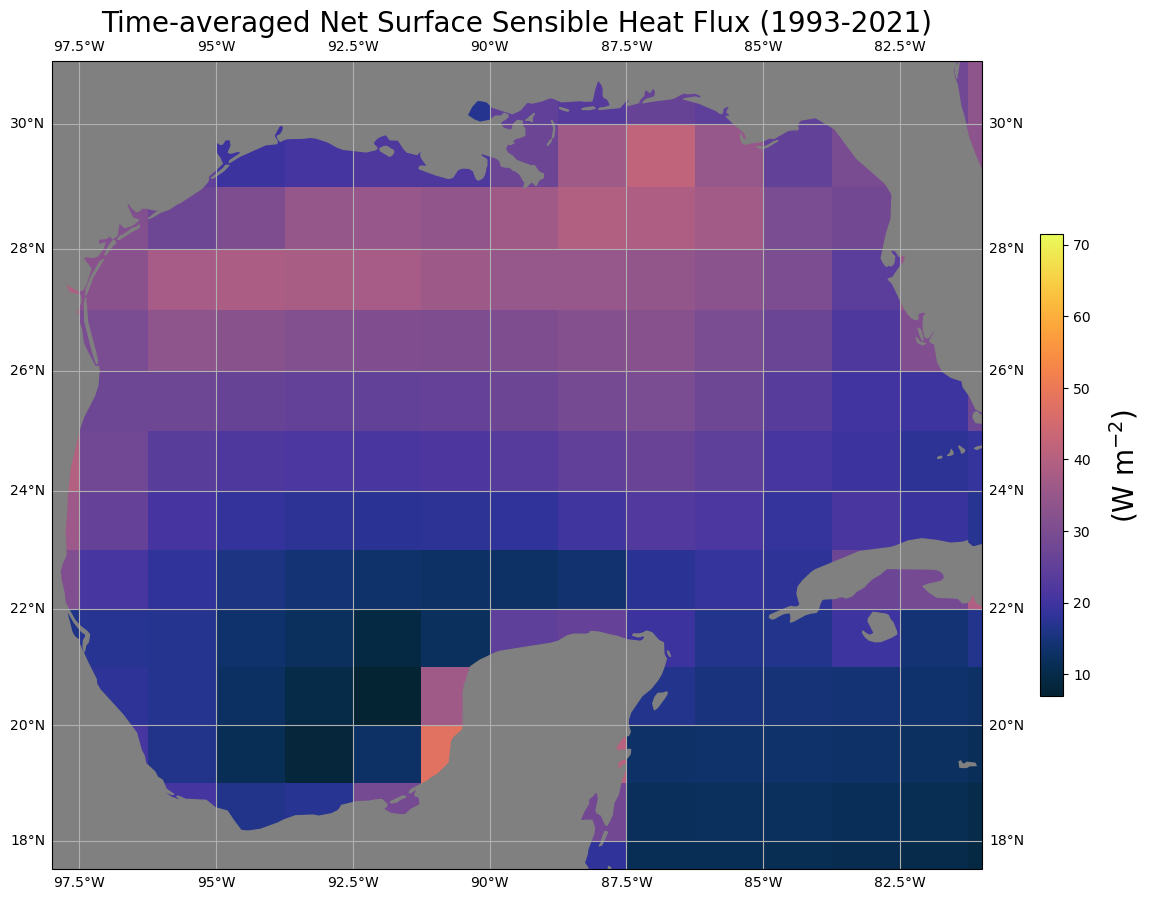

In [17]:
plot_mean(ds.hfss, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)', 
          var_name='Net Surface Sensible Heat Flux', var_title='hfss')

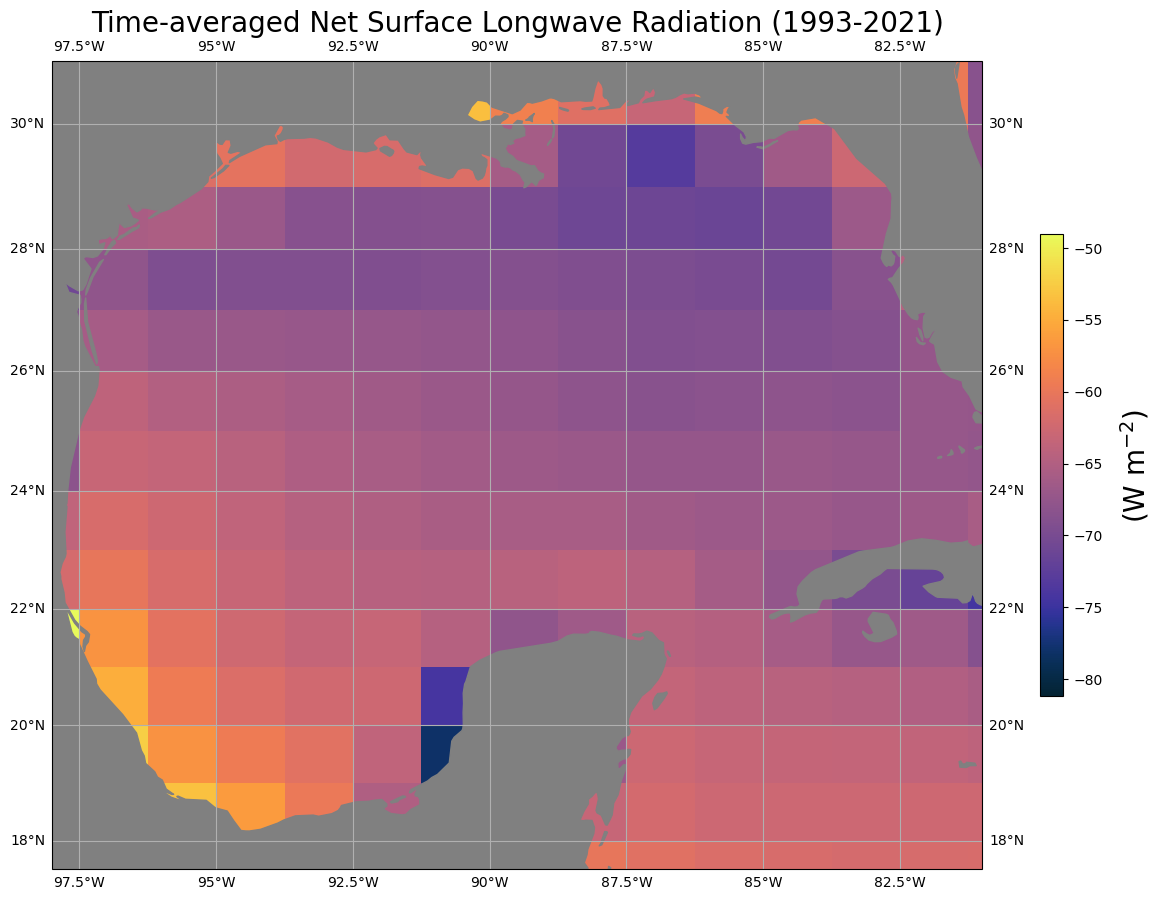

In [18]:
plot_mean(ds.rls, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)', 
          var_name='Net Surface Longwave Radiation', var_title='rls')

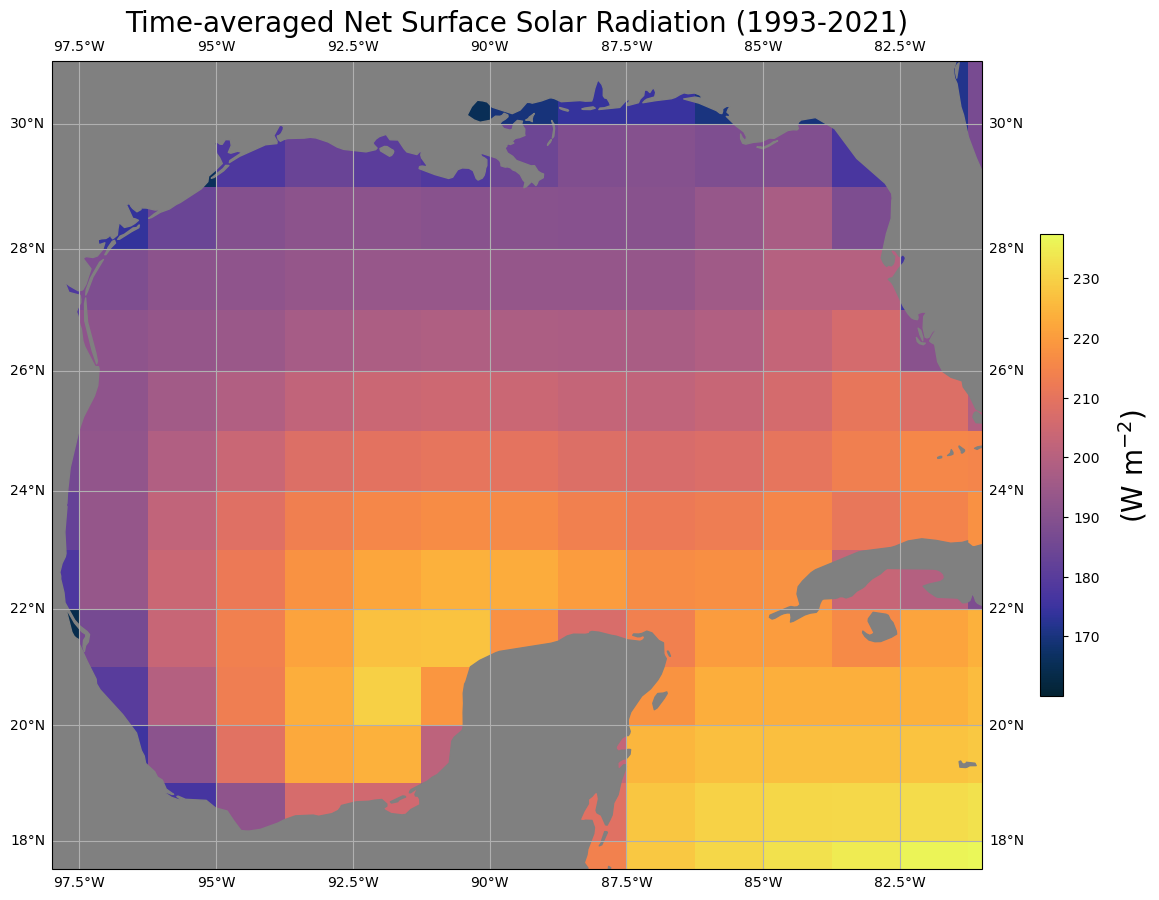

In [19]:
plot_mean(ds.rss, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)', 
          var_name='Net Surface Solar Radiation', var_title='rss')

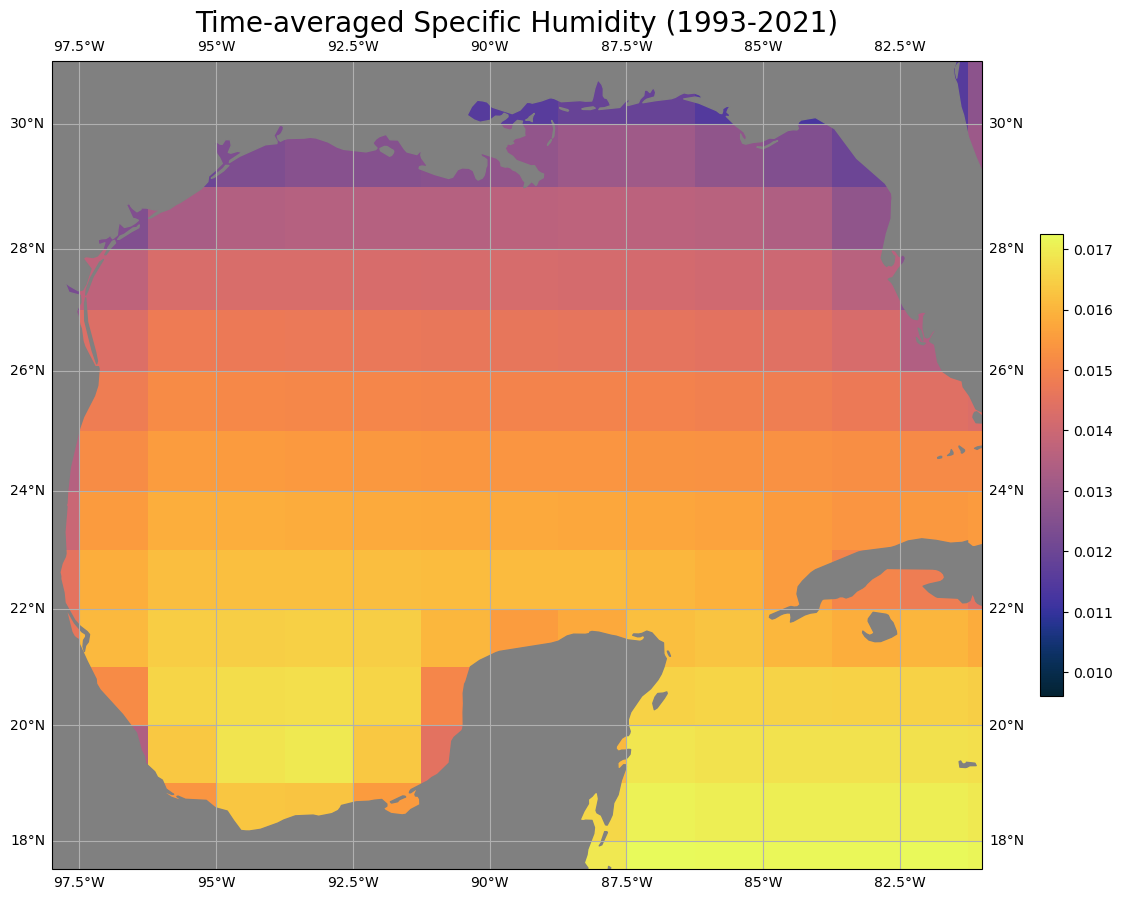

In [20]:
plot_mean(ds.huss, cmap_choice=cmocean.cm.thermal, cbar_label='', 
          var_name='Specific Humidity', var_title='huss')

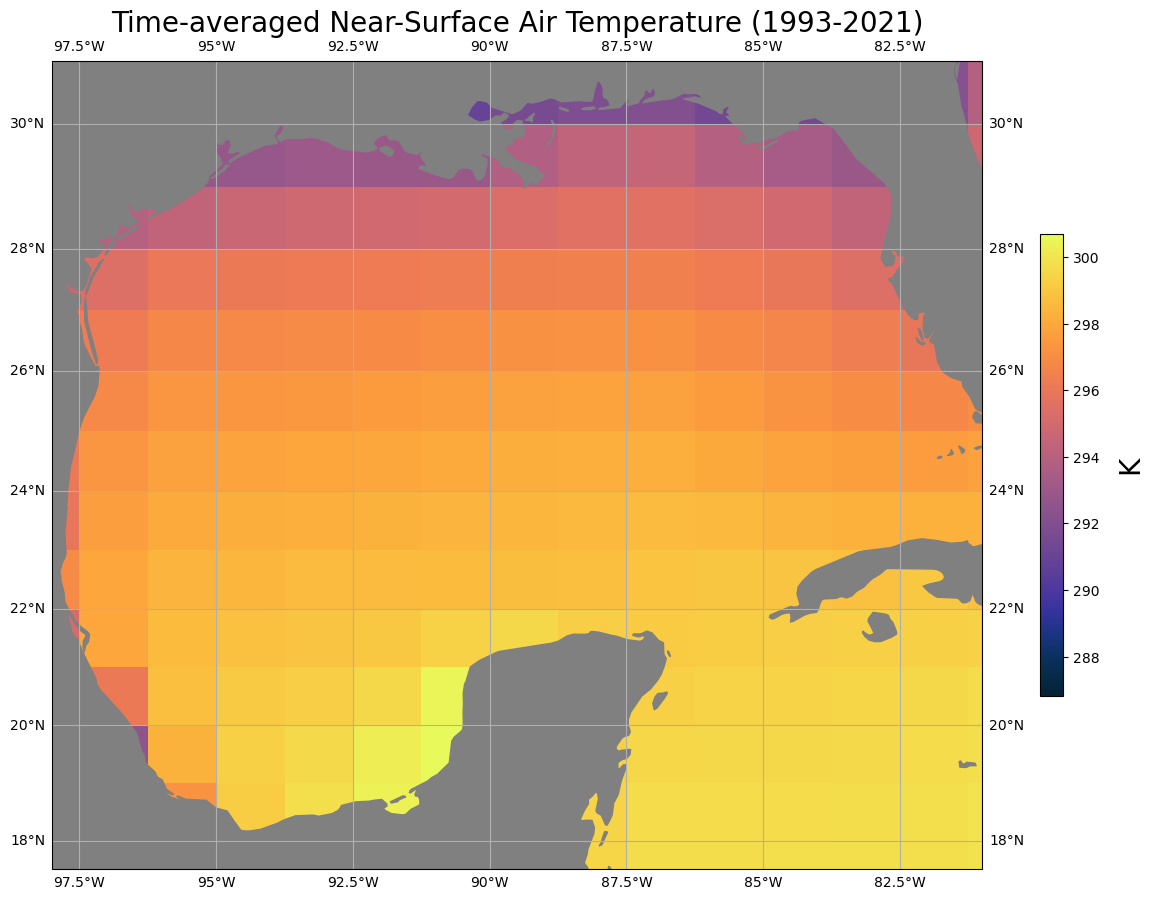

In [21]:
plot_mean(ds.tas, cmap_choice=cmocean.cm.thermal, cbar_label='K', 
          var_name='Near-Surface Air Temperature', var_title='tas')

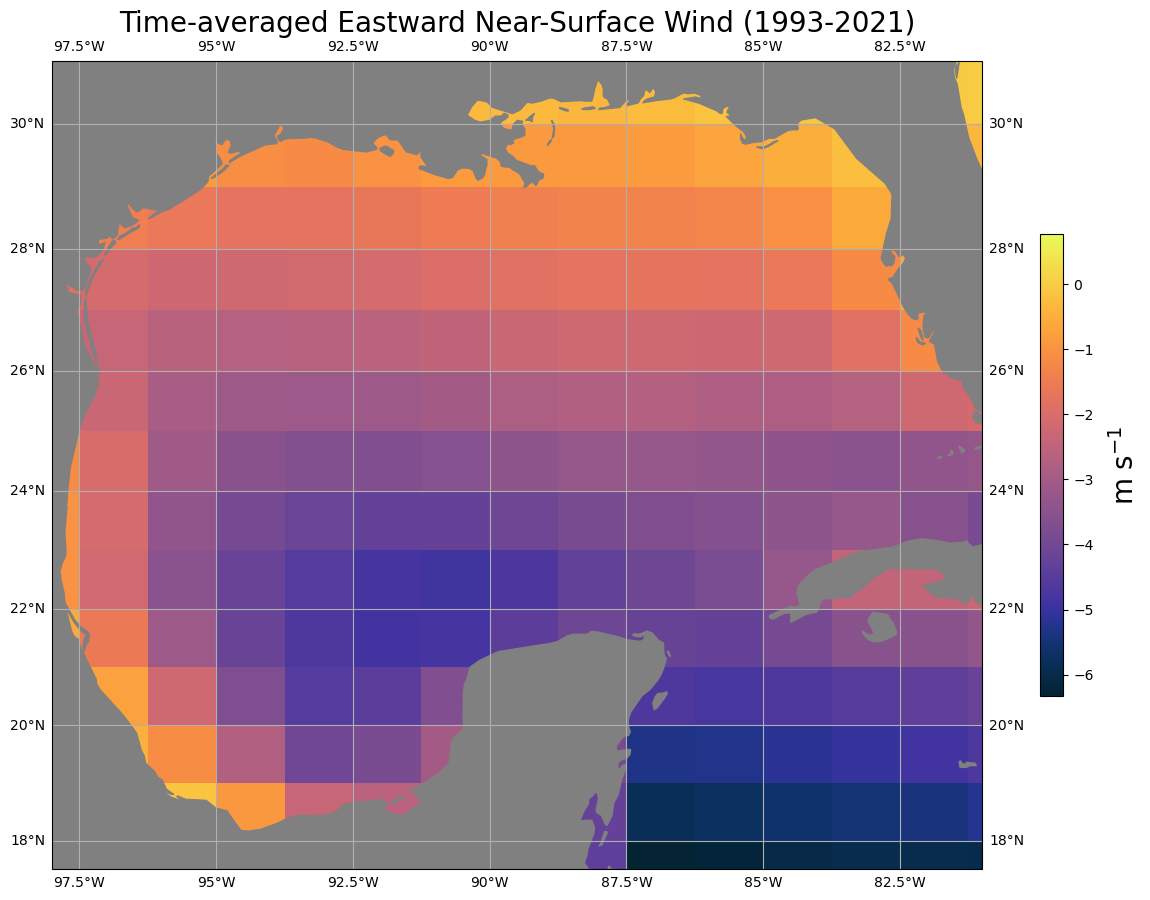

In [22]:
plot_mean(ds.uas, cmap_choice=cmocean.cm.thermal, cbar_label=r'm s$^{-1}$', 
          var_name='Eastward Near-Surface Wind', var_title='uas')

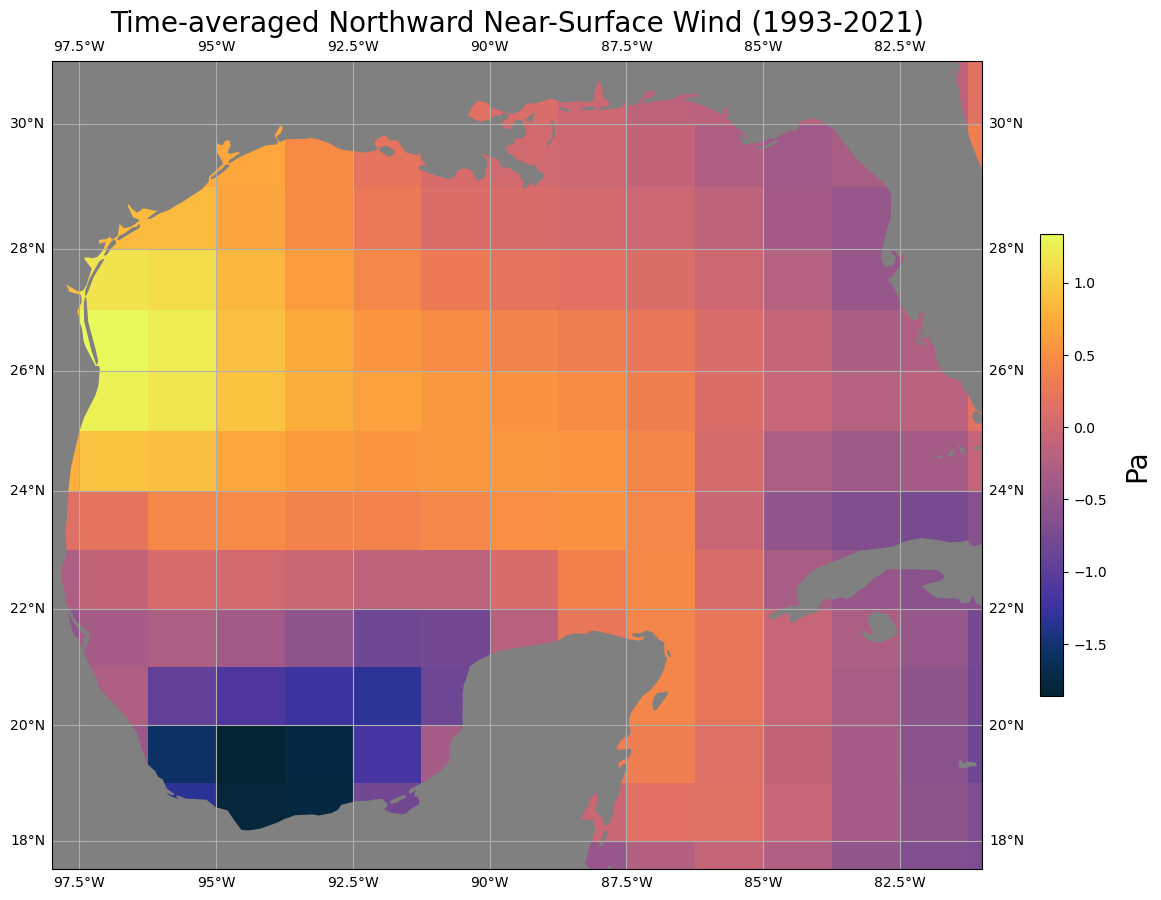

In [23]:
plot_mean(ds.vas, cmap_choice=cmocean.cm.thermal, cbar_label='Pa', 
          var_name='Northward Near-Surface Wind', var_title='vas')

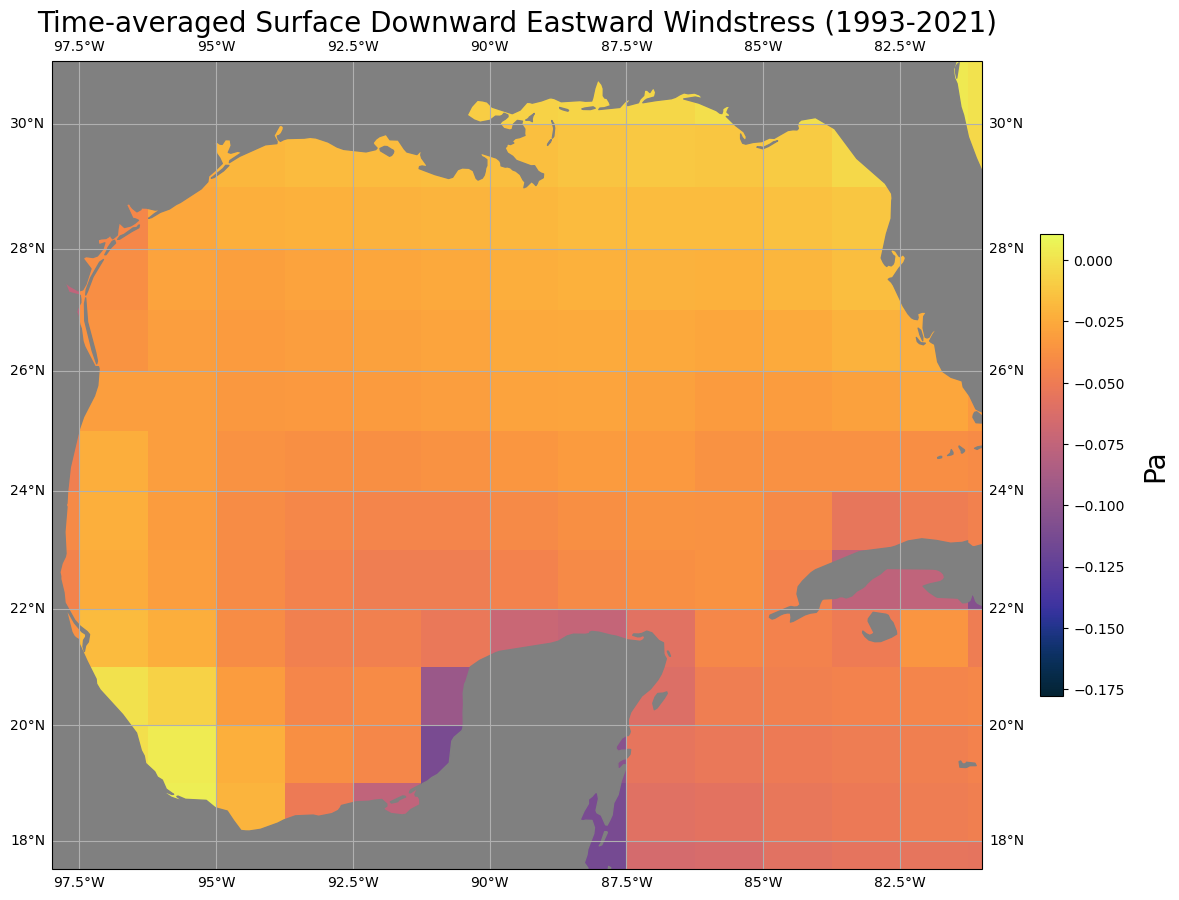

In [25]:
plot_mean(ds.tauu, cmap_choice=cmocean.cm.thermal, cbar_label='Pa', 
          var_name='Surface Downward Eastward Windstress', var_title='tauu')

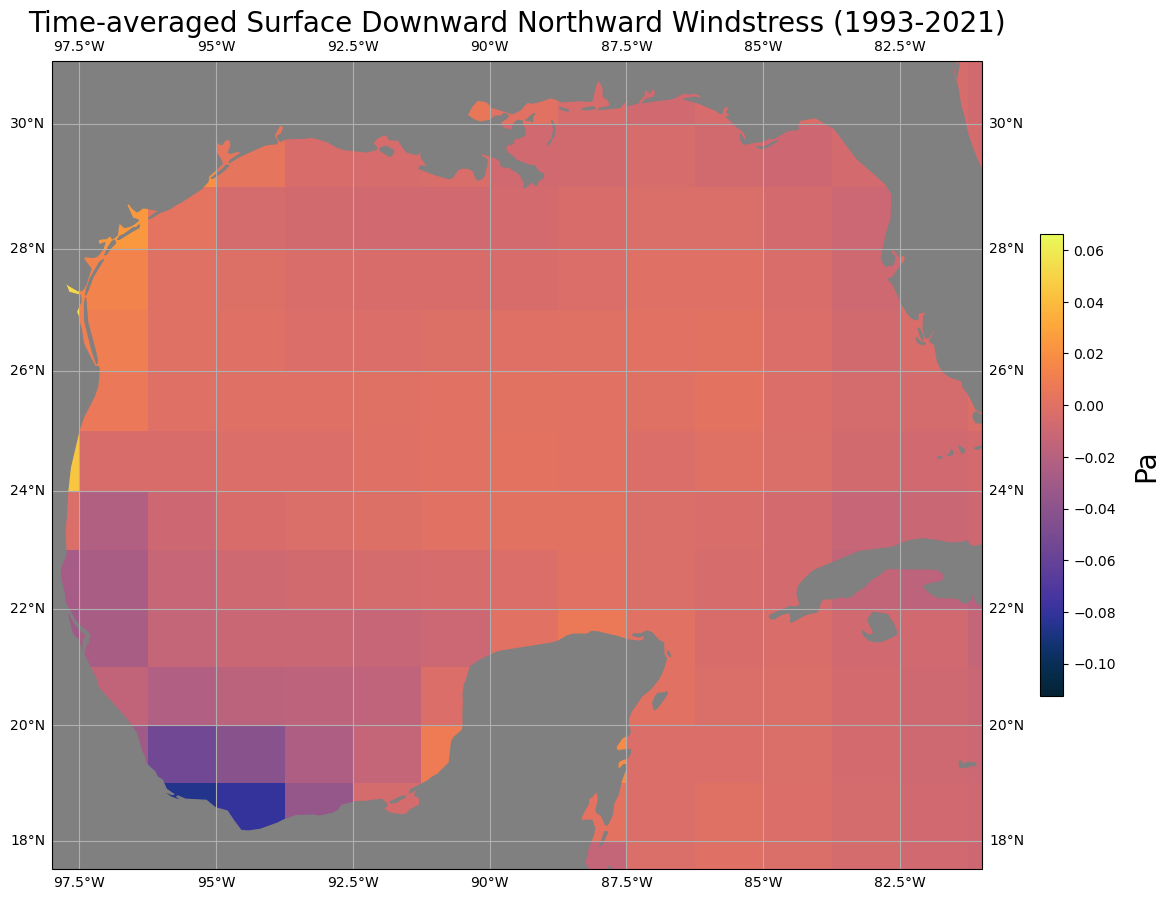

In [26]:
plot_mean(ds.tauv, cmap_choice=cmocean.cm.thermal, cbar_label='Pa', 
          var_name='Surface Downward Northward Windstress', var_title='tauv')

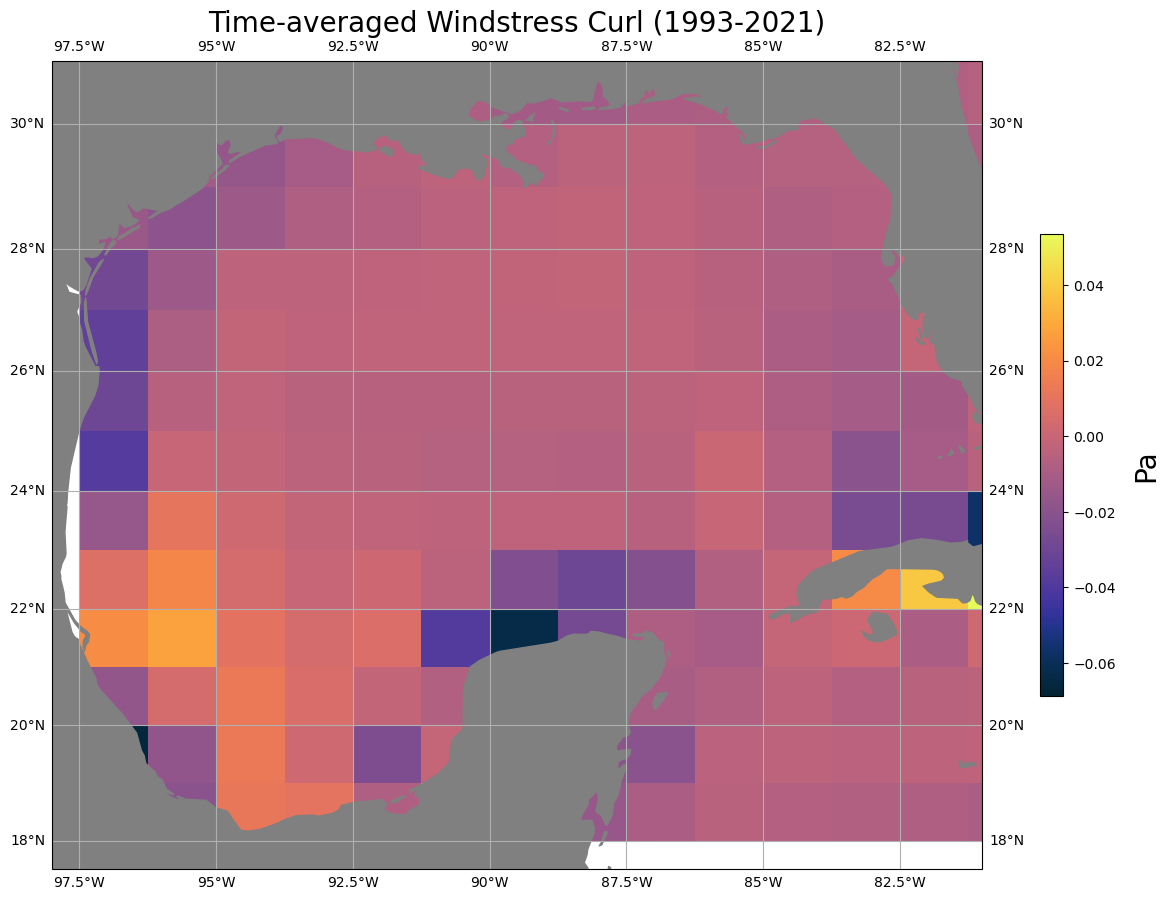

In [27]:
plot_mean(ds.wsc, cmap_choice=cmocean.cm.thermal, cbar_label='Pa', 
          var_name='Windstress Curl', var_title='wsc')

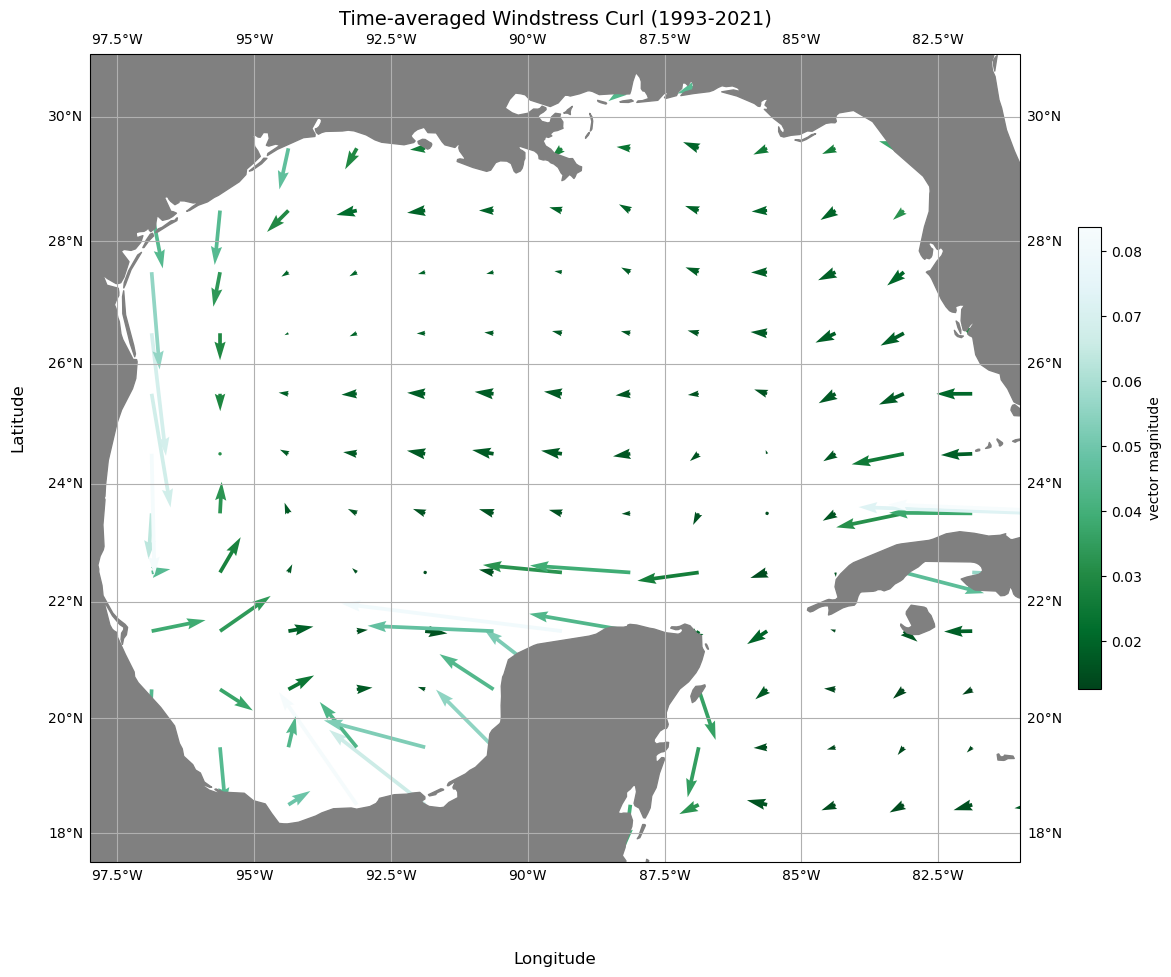

In [28]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
U = -dtauudy.isel(lon=slice(1,None))
V = dtauvdx.isel(lat=slice(1,None))
C = np.sqrt(U**2 + V**2).mean('time') # Magnitude of the vectors for coloring
im = ax.quiver(ds.lon[1:], 
               ds.lat[1:], 
               U.mean('time').values, 
               V.mean('time').values,
               C, cmap='BuGn_r', width=0.004, transform=ccrs.PlateCarree())#, 'green', 'red']))#, vmin=34, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("vector magnitude")

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Time-averaged Windstress Curl (1993-2021)', fontsize=14);
#plt.savefig('/work5/stb/MHW-gfdl/paper-figs/horiz_vel_avg.pdf');

/nbhome/Shanice.Bailey/conda/envs/bai_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'vcenter'
  result = super().contourf(*args, **kwargs)


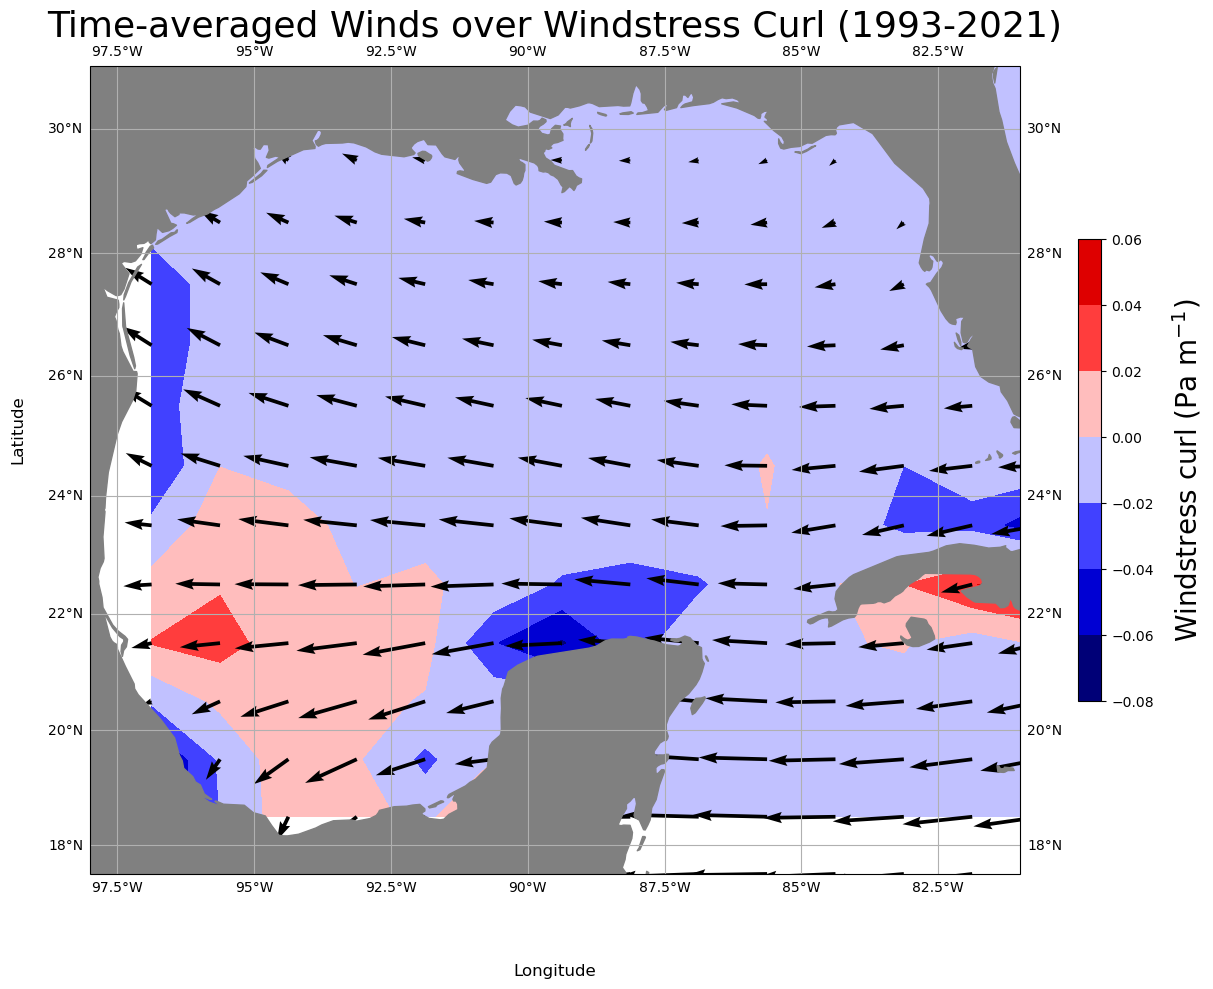

In [30]:
#positive windstress curl is upwelling
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
U = ds.uas.mean('time')
V = ds.vas.mean('time')
#C = ds.wsc.mean('time')
cf = ax.contourf(ds.lon, ds.lat, ds.wsc.mean('time'), cmap='seismic', 
                 vmin=-0.08, vcenter=0, vmax=0.08, transform=ccrs.PlateCarree())
im = ax.quiver(ds.lon, ds.lat,
               U.values, 
               V.values,
               color='k', width=0.004, transform=ccrs.PlateCarree())#, 'green', 'red']))#, vmin=34, vmax=35)
cb = fig.colorbar(cf, ax=ax, shrink=0.4)
cb.set_label(r"Windstress curl (Pa m$^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Time-averaged Winds over Windstress Curl (1993-2021)', fontsize=26);
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/ESM4/time-mean/time-mean_wsc-over-winds.pdf');

## Calculate linear trend for each data field

In [11]:
trend_ds = ds.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)
trend_sst = sst.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)

## Trends (spatial maps)

In [22]:
print('Max: ', trend_sst.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_sst.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.016187805965029098 ˚C/yr 
Min:  -0.009564373410980787 ˚C/yr


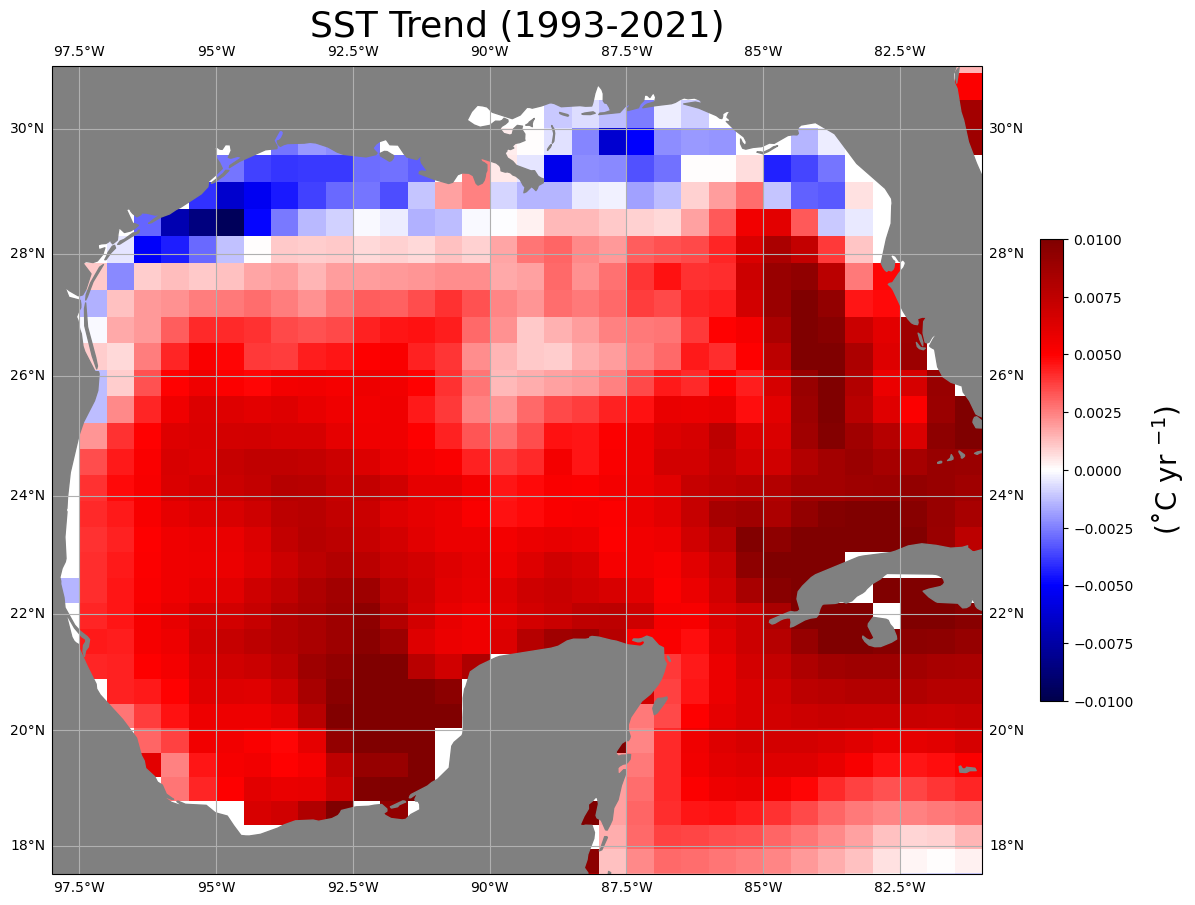

In [25]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
d = trend_sst.polyfit_coefficients[0]
norm = TwoSlopeNorm(vmin=-0.01, vcenter=0, vmax=0.01)
im = ax.pcolormesh(d.xh, d.yh, d, transform=ccrs.PlateCarree(), 
                   norm=norm, cmap='seismic')
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('(˚C yr $^{-1}$)', labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False
    
plt.title('SST Trend (1993-2021)', fontsize=26);
plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/ESM4/atm/trend_spatio_SST.pdf');

In [15]:
def plot_trend(da, var_title, cbar_label, v_min, v_max, cmap_choice, diverge=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    if diverge==True:
        d = da
        norm = TwoSlopeNorm(vmin=v_min, vcenter=0, vmax=v_max)
        im = ax.pcolormesh(d.lon, d.lat, d, transform=ccrs.PlateCarree(), 
                           norm=norm, cmap=cmap_choice)
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{var_title} Trend (1993-2021)', fontsize=26);
    else:
        d = da
        im = ax.pcolormesh(d.lon, d.lat, d, transform=ccrs.PlateCarree(), 
                           vmin=v_min, vmax=v_max, cmap=cmap_choice)#norm=LogNorm(),
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{var_title} Trend (1993-2021)', fontsize=26)
    plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/ESM4/atm/trend_spatio_{var_title}.pdf');

In [33]:
for i in ds.data_vars:
    print(f'Max {i}: ', trend_ds[f'{i}_polyfit_coefficients'][0].max().values, 
          ds[f'{i}'].attrs['units'], '/ yr',
          f'\nMin {i}: ', trend_ds[f'{i}_polyfit_coefficients'][0].min().values, 
          ds[f'{i}'].attrs['units'], '/ yr')

Max clt:  0.16650821521613426 % / yr 
Min clt:  -0.1613581025383342 % / yr
Max hfls:  0.275126505495479 W m-2 / yr 
Min hfls:  -0.4915917453872257 W m-2 / yr
Max hfss:  0.44260148342875083 W m-2 / yr 
Min hfss:  -0.2565835247500483 W m-2 / yr
Max huss:  3.0184664205188687e-05 1.0 / yr 
Min huss:  -8.56447370744434e-06 1.0 / yr
Max tas:  0.04504482178769354 K / yr 
Min tas:  -0.037003798102482395 K / yr
Max tauu:  0.00015856333028223003 Pa / yr 
Min tauu:  -0.0008084979712897363 Pa / yr
Max tauv:  0.0004440901406200394 Pa / yr 
Min tauv:  -0.00040772474119398535 Pa / yr
Max uas:  0.039093298307267564 m s-1 / yr 
Min uas:  -0.024364693687114018 m s-1 / yr
Max vas:  0.031207963438419032 m s-1 / yr 
Min vas:  -0.025431619168051783 m s-1 / yr
Max rls:  0.23220563060196325 W m-2 / yr 
Min rls:  -0.15818985497033566 W m-2 / yr
Max rss:  0.3523469273716146 W m-2 / yr 
Min rss:  -0.21629078409038585 W m-2 / yr
Max wsc:  0.00030561732551940125 Pa m-1 / yr 
Min wsc:  -0.0003942781636067604 Pa m-1

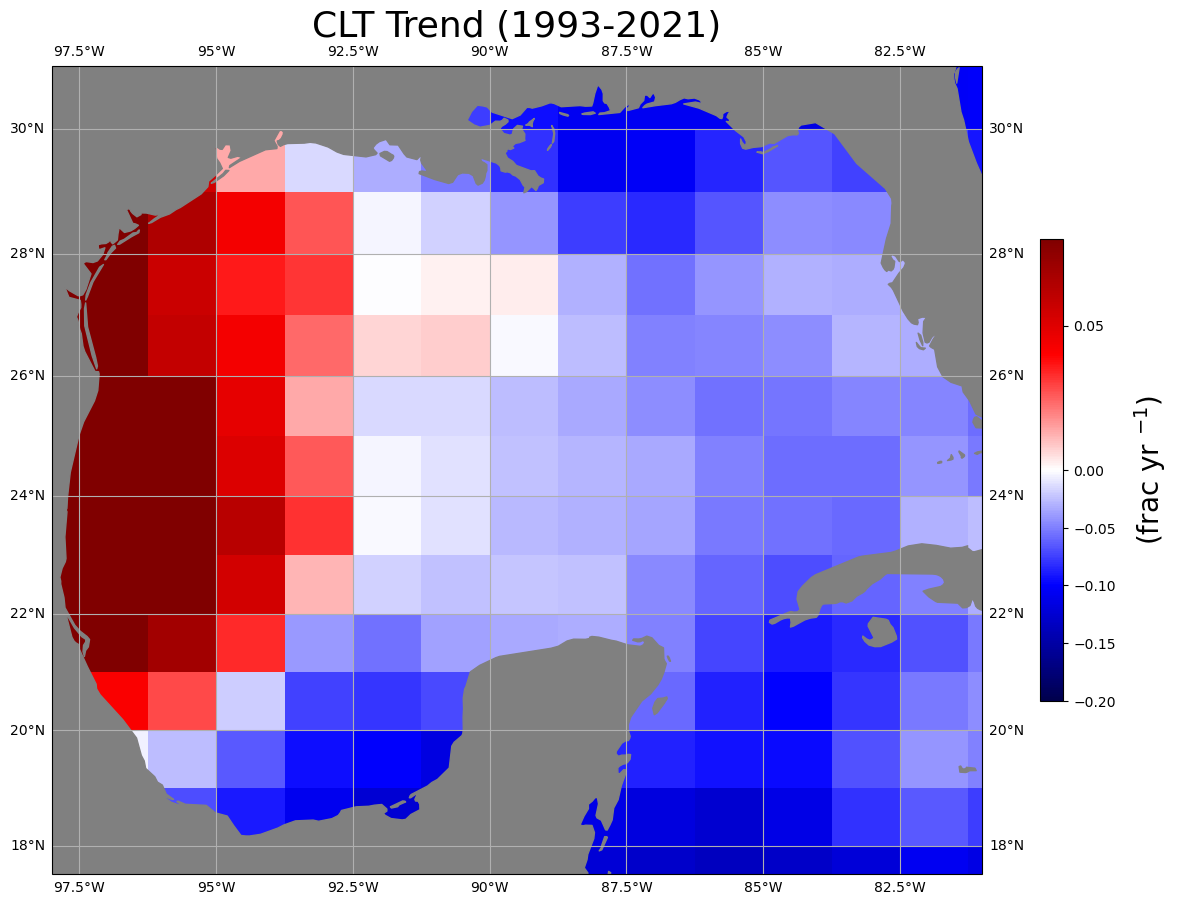

In [37]:
plot_trend(trend_ds.clt_polyfit_coefficients[0], 'CLT', '(frac yr $^{-1}$)', -0.2, 0.08, cmap_choice='seismic')

In [38]:
print('Max: ', trend_ds.rss_polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_ds.rss_polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.3523469273716146 W/m2/yr 
Min:  -0.21629078409038585 W/m2/yr


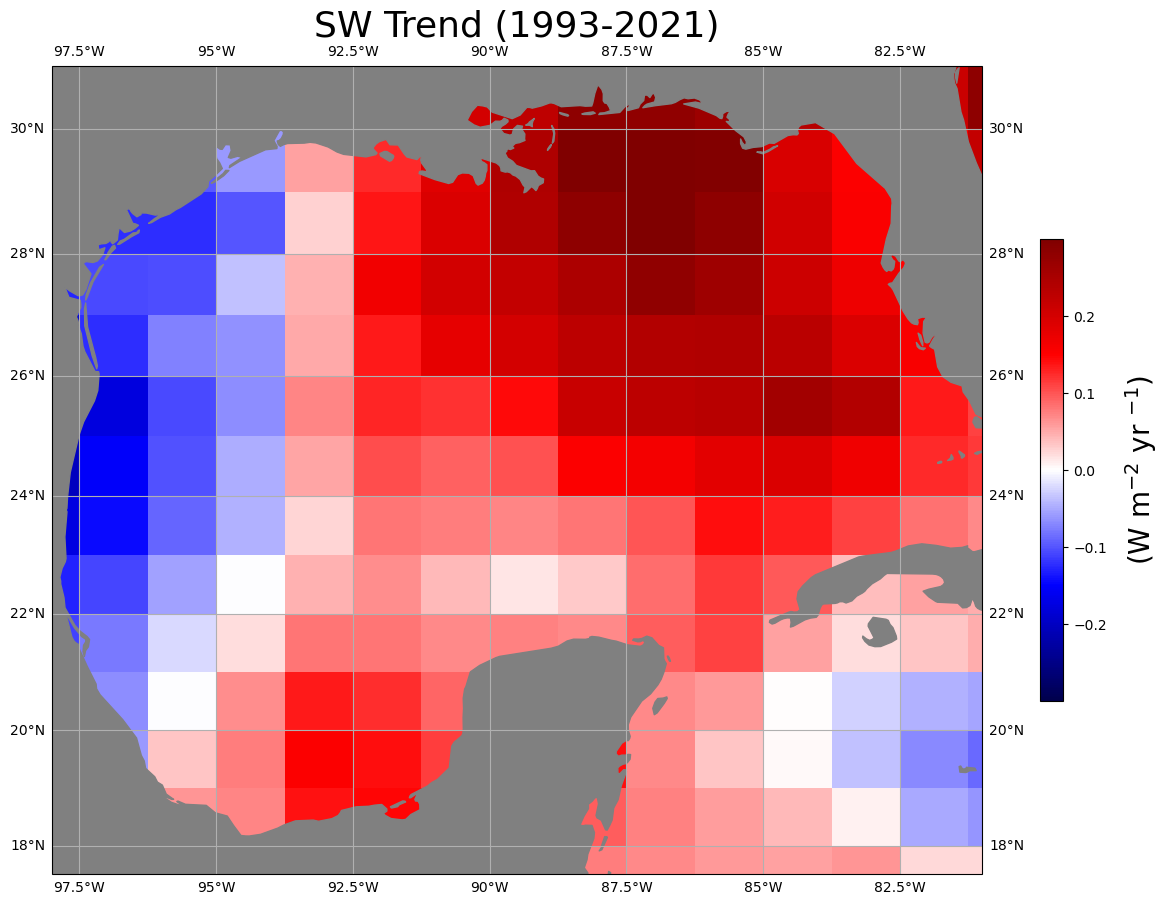

In [39]:
plot_trend(trend_ds.rss_polyfit_coefficients[0], 'SW', '(W m$^{-2}$ yr $^{-1}$)', -0.3, 0.3, cmap_choice='seismic')

In [40]:
print('Max: ', trend_ds.rls_polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_ds.rls_polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.23220563060196325 W/m2/yr 
Min:  -0.15818985497033566 W/m2/yr


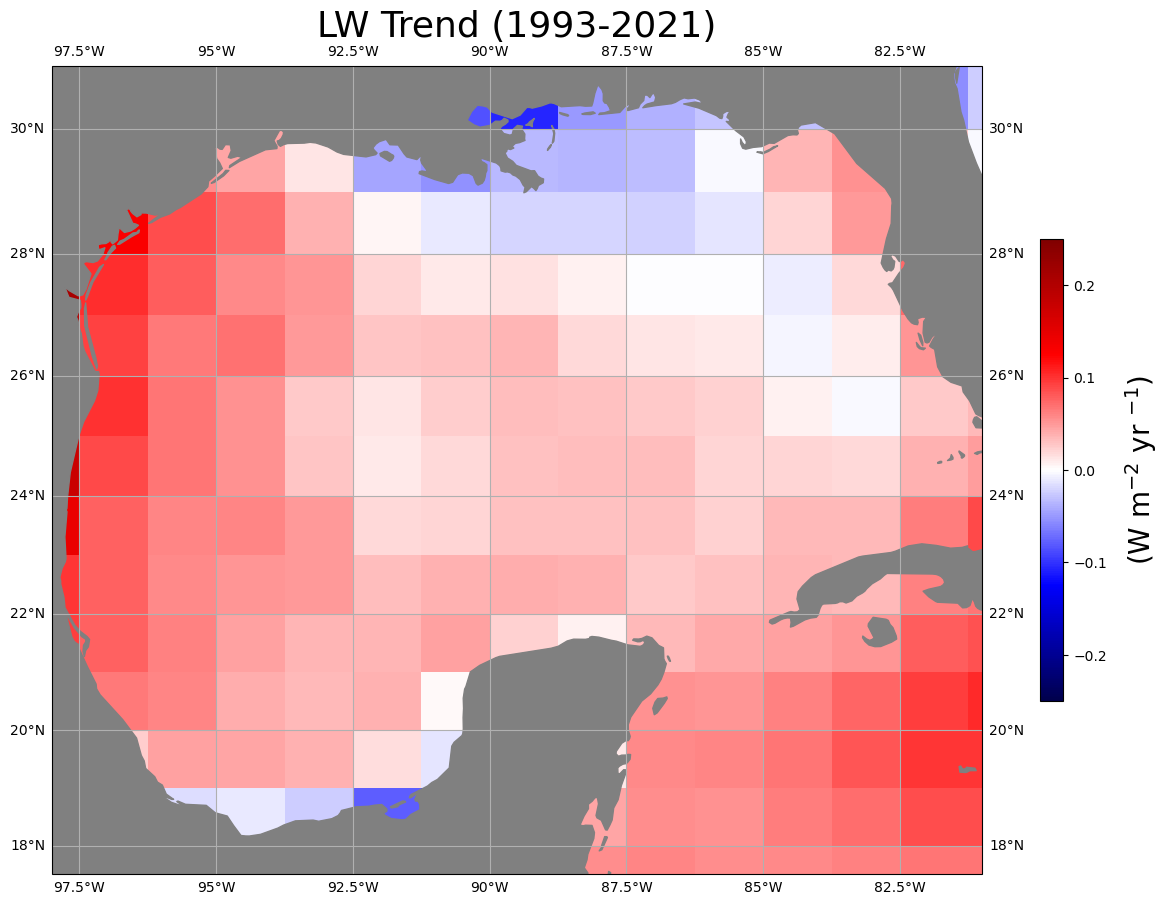

In [41]:
plot_trend(trend_ds.rls_polyfit_coefficients[0], 'LW', '(W m$^{-2}$ yr $^{-1}$)', -0.25, 0.25, cmap_choice='seismic')

In [42]:
print('Max: ', trend_ds.hfls_polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_ds.hfls_polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.275126505495479 W/m2/yr 
Min:  -0.4915917453872257 W/m2/yr


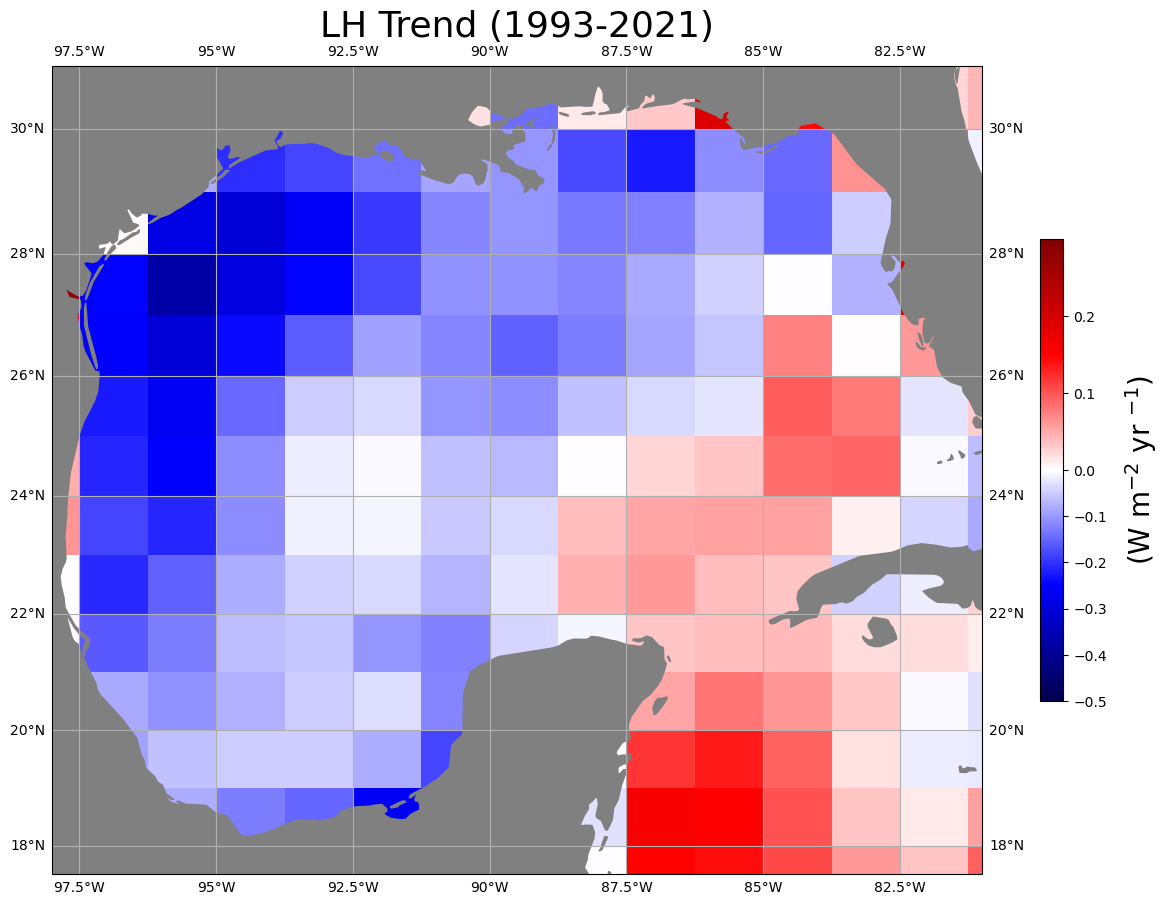

In [43]:
plot_trend(trend_ds.hfls_polyfit_coefficients[0], 'LH', '(W m$^{-2}$ yr $^{-1}$)', -0.5, 0.3, cmap_choice='seismic')

In [44]:
print('Max: ', trend_ds.hfss_polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_ds.hfss_polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.44260148342875083 W/m2/yr 
Min:  -0.2565835247500483 W/m2/yr


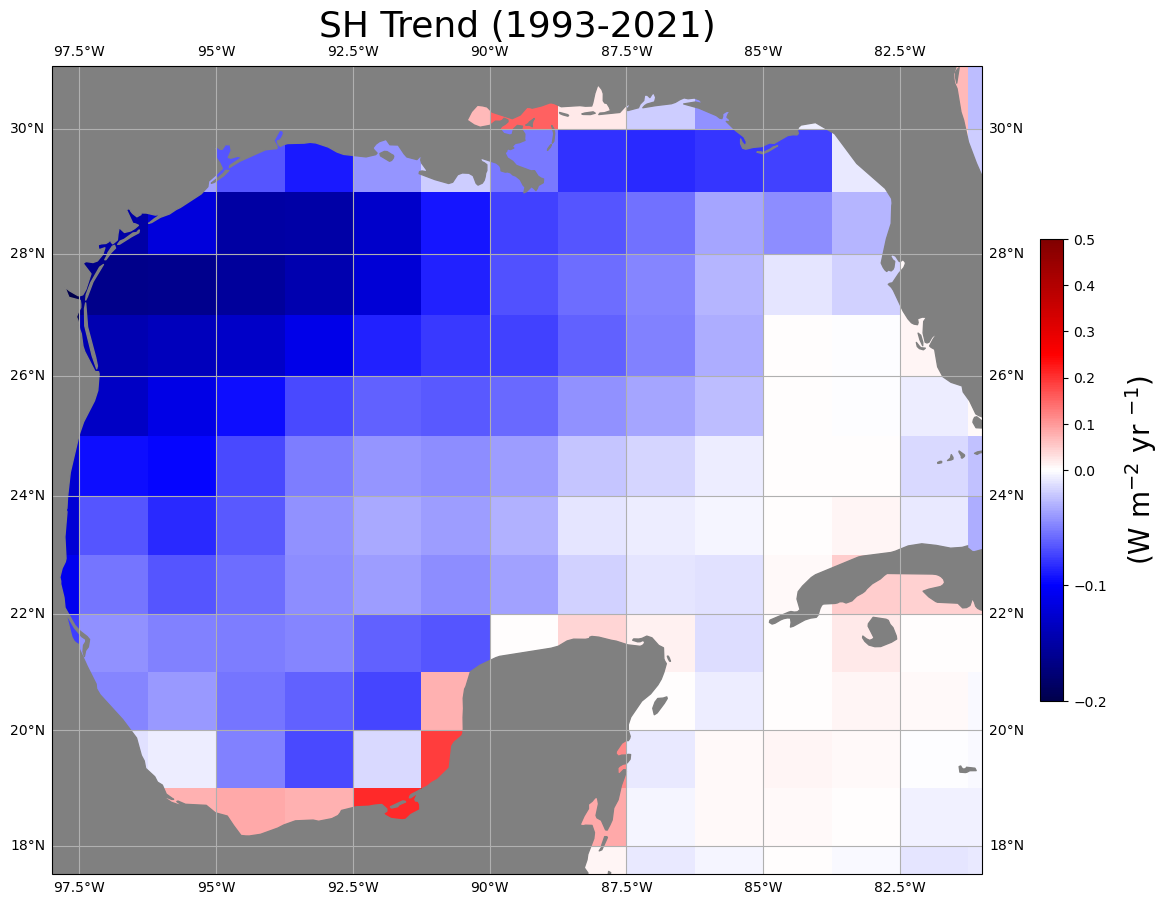

In [45]:
plot_trend(trend_ds.hfss_polyfit_coefficients[0], 'SH', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.2, 0.5, cmap_choice='seismic')

In [13]:
print('Max: ', trend_ds.huss_polyfit_coefficients[0].max().values, '/yr', 
      '\nMin: ', trend_ds.huss_polyfit_coefficients[0].min().values, '/yr')

Max:  3.0184664205188687e-05 /yr 
Min:  -8.56447370744434e-06 /yr


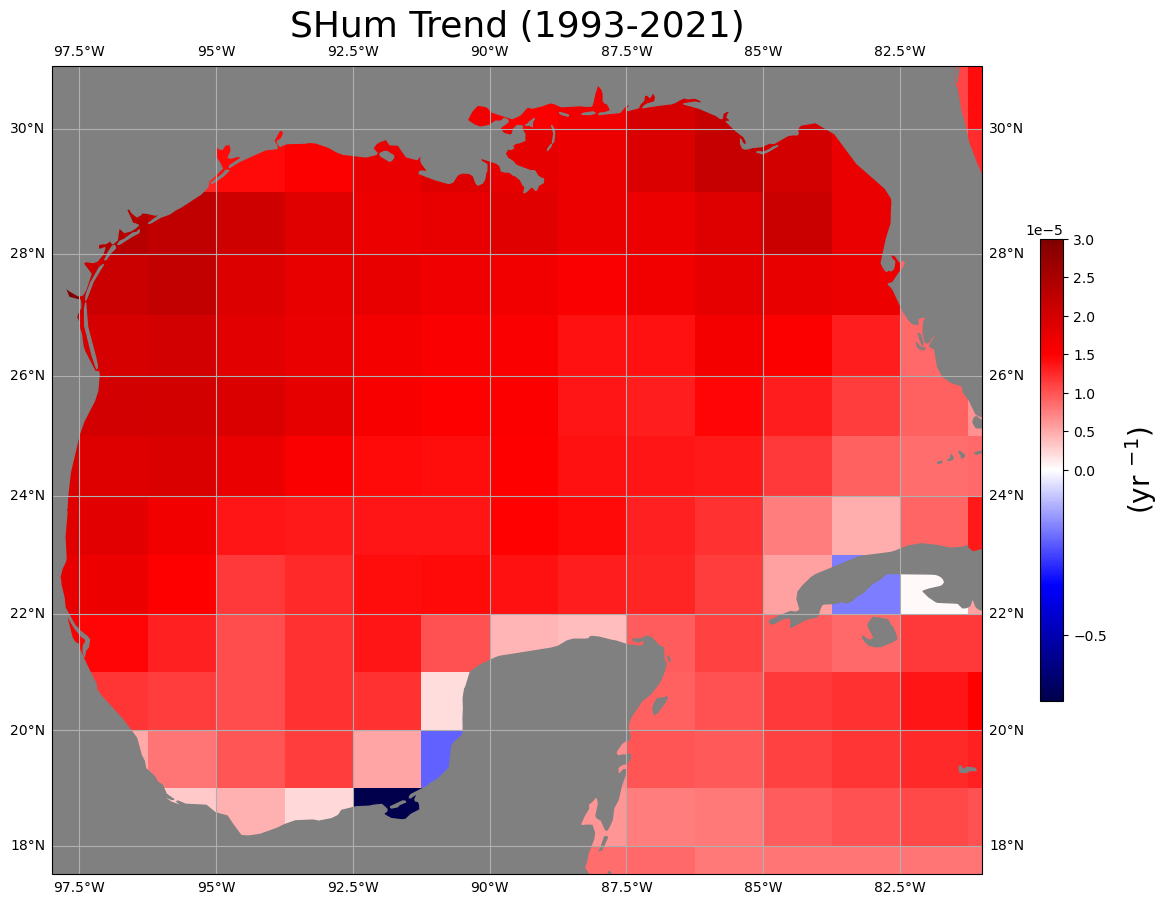

In [17]:
plot_trend(trend_ds.huss_polyfit_coefficients[0], 'SHum', '(yr $^{-1}$)', 
           -7e-6, 3e-5, cmap_choice='seismic')

In [19]:
print('Max: ', trend_ds.tas_polyfit_coefficients[0].max().values, 'K/yr', 
      '\nMin: ', trend_ds.tas_polyfit_coefficients[0].min().values, 'K/yr')

Max:  0.04504482178769354 K/yr 
Min:  -0.037003798102482395 K/yr


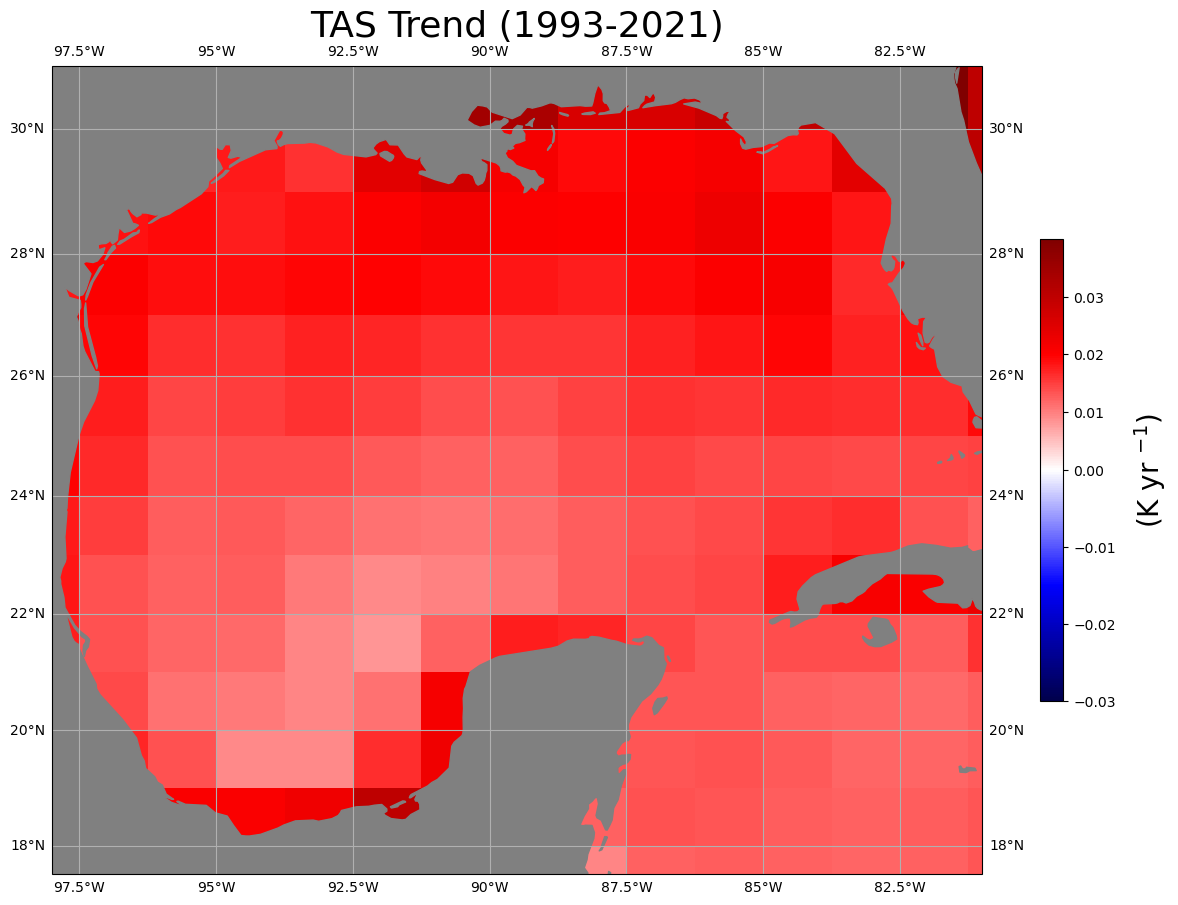

In [21]:
plot_trend(trend_ds.tas_polyfit_coefficients[0], 'TAS', '(K yr $^{-1}$)', -0.03, 0.04, cmap_choice='seismic')

In [48]:
print('Max: ', trend_ds.uas_polyfit_coefficients[0].max().values, 'm/s', 
      '\nMin: ', trend_ds.uas_polyfit_coefficients[0].min().values, 'm/s')

Max:  0.039093298307267564 m/s 
Min:  -0.024364693687114018 m/s


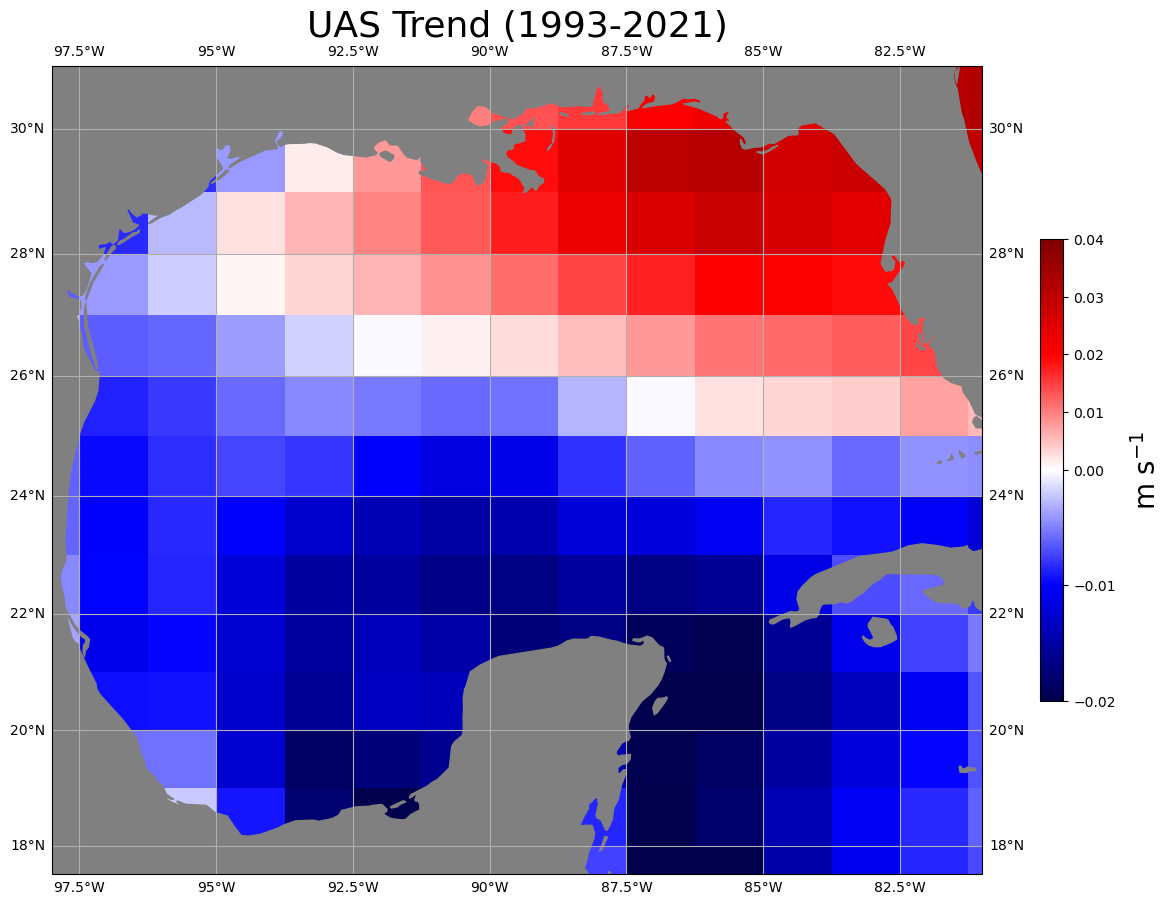

In [49]:
plot_trend(trend_ds.uas_polyfit_coefficients[0], 'UAS', r'm s$^{-1}$', 
           -0.02, 0.04, cmap_choice='seismic')

In [50]:
print('Max: ', trend_ds.vas_polyfit_coefficients[0].max().values, 'm/s', 
      '\nMin: ', trend_ds.vas_polyfit_coefficients[0].min().values, 'm/s')

Max:  0.031207963438419032 m/s 
Min:  -0.025431619168051783 m/s


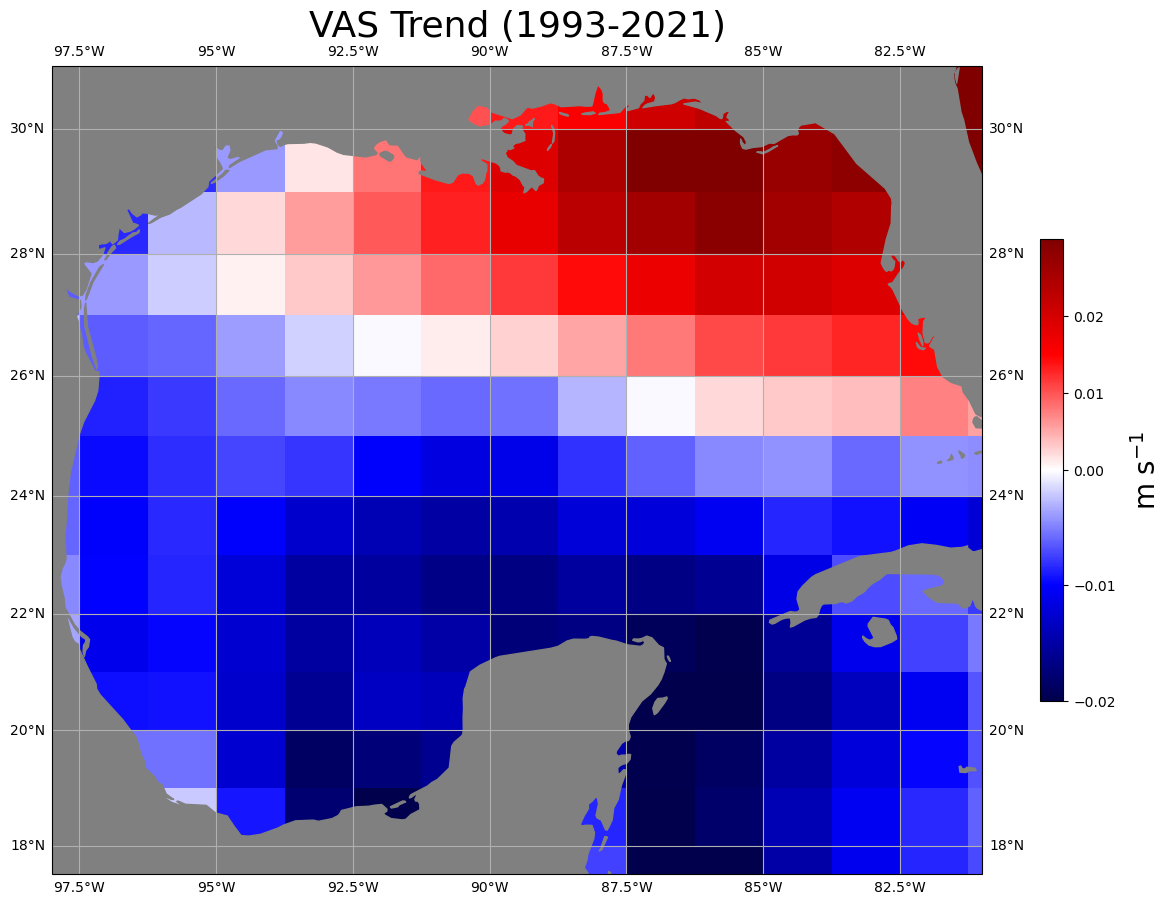

In [51]:
plot_trend(trend_ds.uas_polyfit_coefficients[0], 'VAS', r'm s$^{-1}$', 
           -0.02, 0.03, cmap_choice='seismic')

In [52]:
print('Max: ', trend_ds.tauu_polyfit_coefficients[0].max().values, 'Pa', 
      '\nMin: ', trend_ds.tauu_polyfit_coefficients[0].min().values, 'Pa')

Max:  0.00015856333028223003 Pa 
Min:  -0.0008084979712897363 Pa


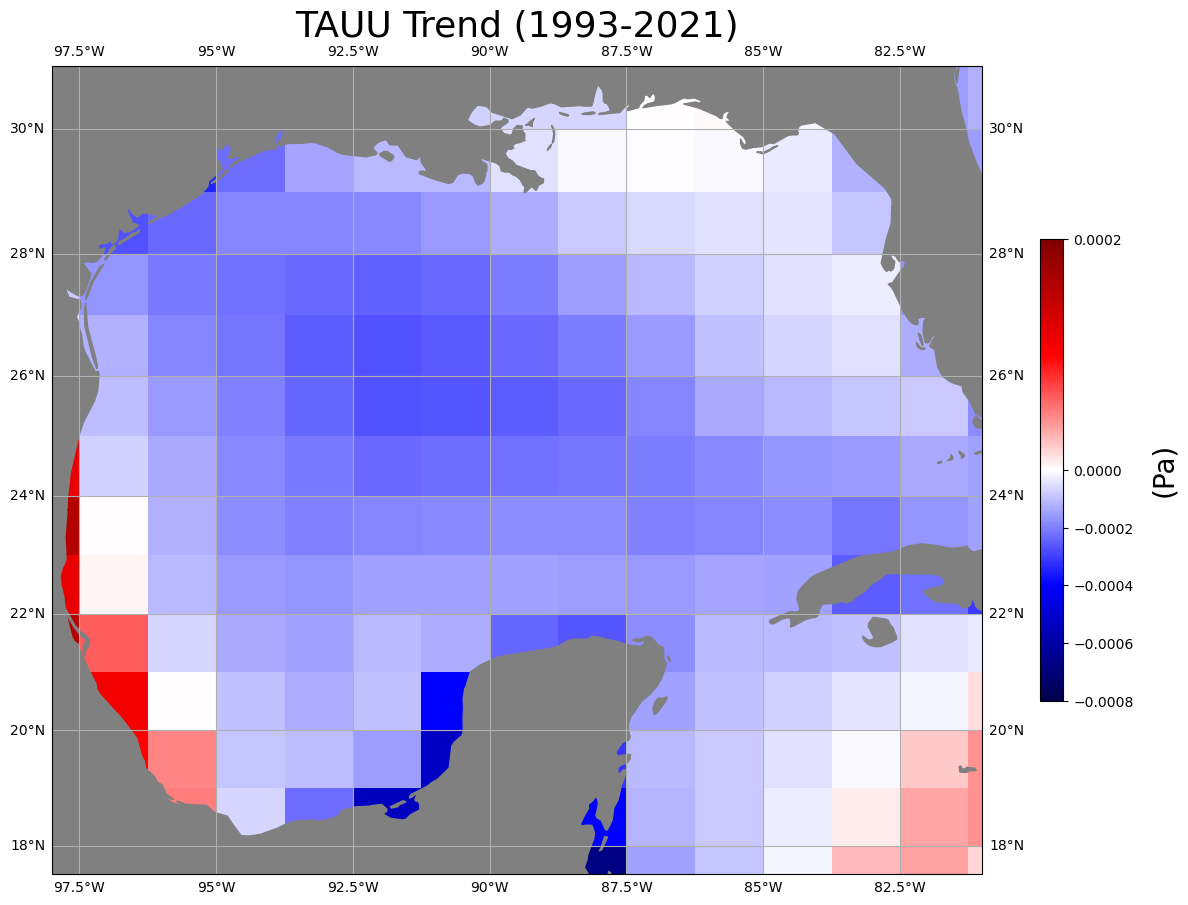

In [53]:
plot_trend(trend_ds.tauu_polyfit_coefficients[0], 'TAUU', '(Pa)', 
           -8e-4, 2e-4, cmap_choice='seismic')

In [54]:
print('Max: ', trend_ds.tauv_polyfit_coefficients[0].max().values, 'Pa', 
      '\nMin: ', trend_ds.tauv_polyfit_coefficients[0].min().values, 'Pa')

Max:  0.0004440901406200394 Pa 
Min:  -0.00040772474119398535 Pa


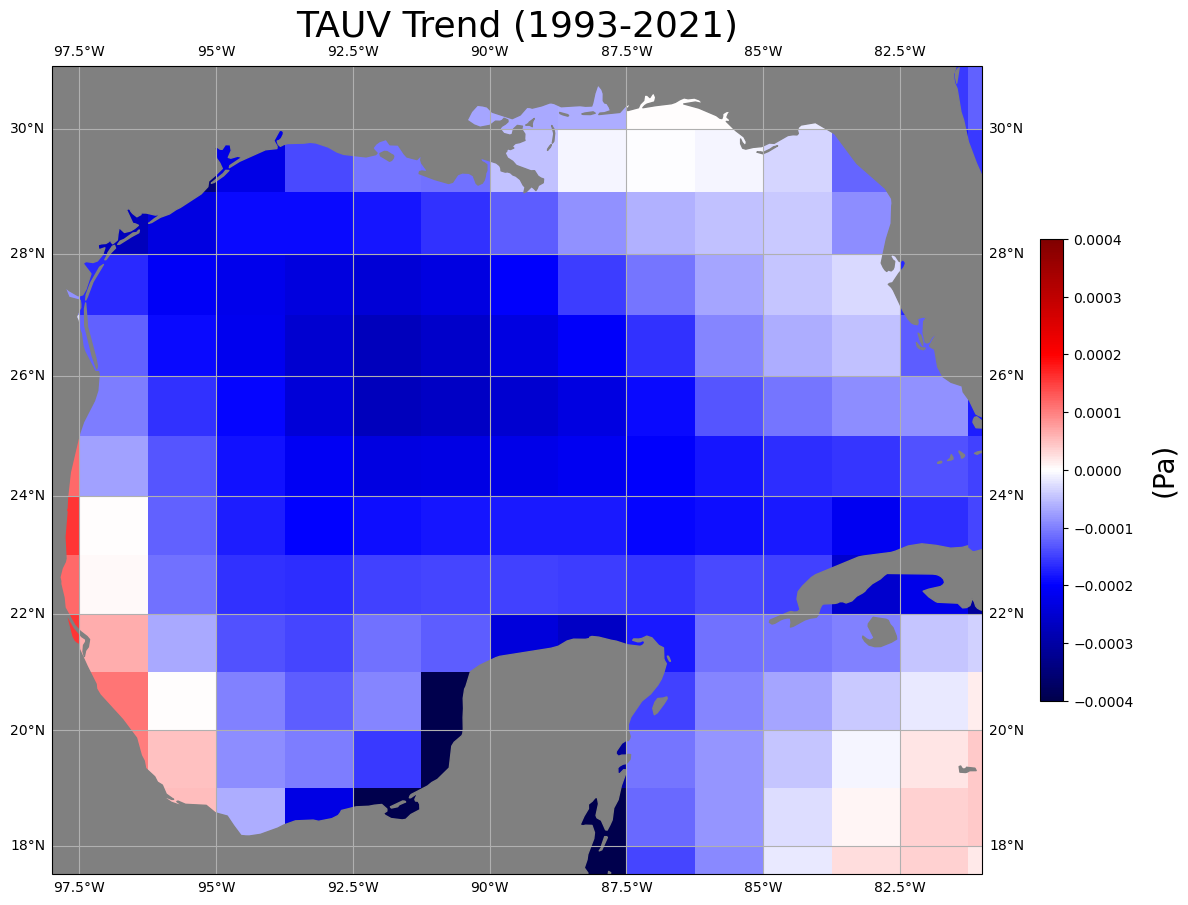

In [55]:
plot_trend(trend_ds.tauu_polyfit_coefficients[0], 'TAUV', '(Pa)', 
           -4e-4, 4e-4, cmap_choice='seismic')

In [56]:
print('Max: ', trend_ds.wsc_polyfit_coefficients[0].max().values, 'Pa/m', 
      '\nMin: ', trend_ds.wsc_polyfit_coefficients[0].min().values, 'Pa/m')

Max:  0.00030561732551940125 Pa/m 
Min:  -0.0003942781636067604 Pa/m


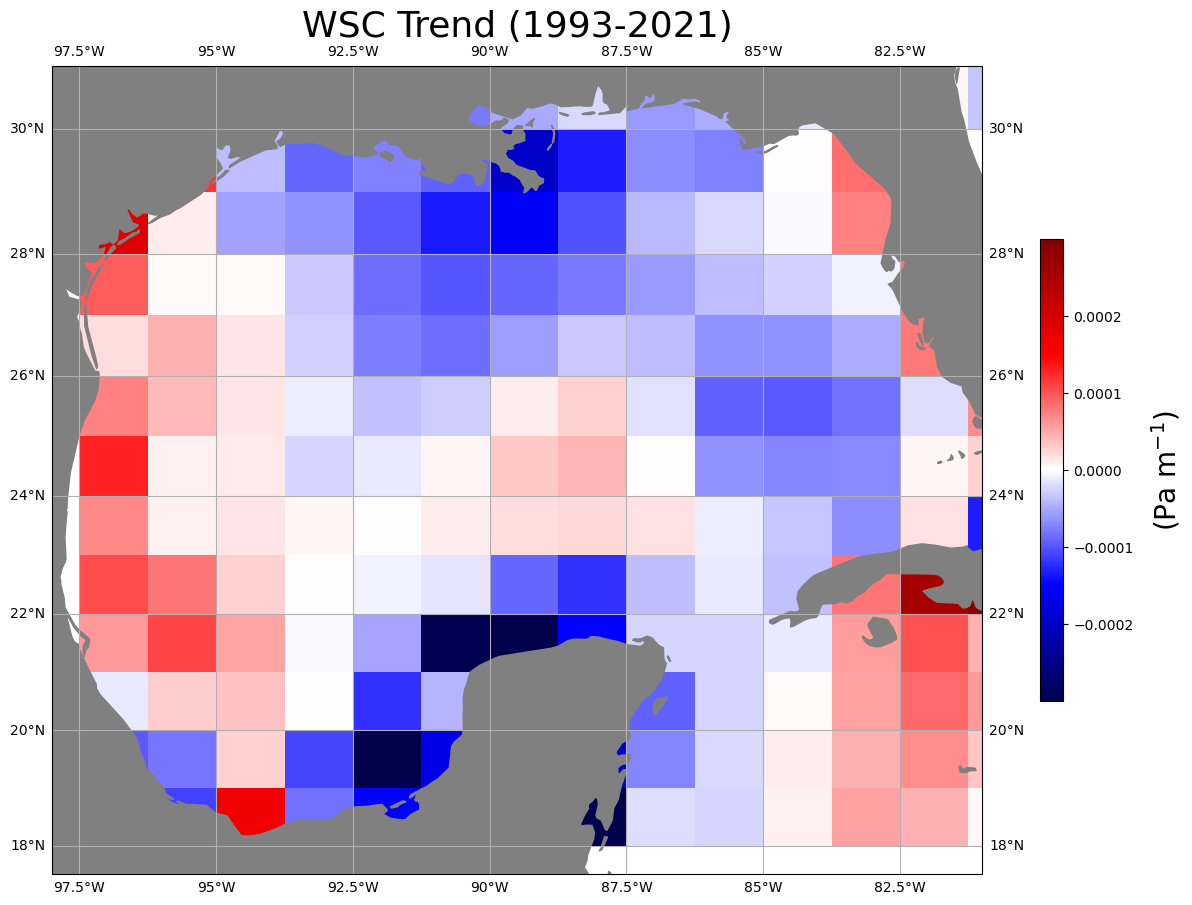

In [57]:
plot_trend(trend_ds.wsc_polyfit_coefficients[0], 'WSC', r'(Pa m$^{-1}$)', 
           -3e-4, 3e-4, cmap_choice='seismic')

/nbhome/Shanice.Bailey/conda/envs/bai_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'vcenter'
  result = super().contourf(*args, **kwargs)


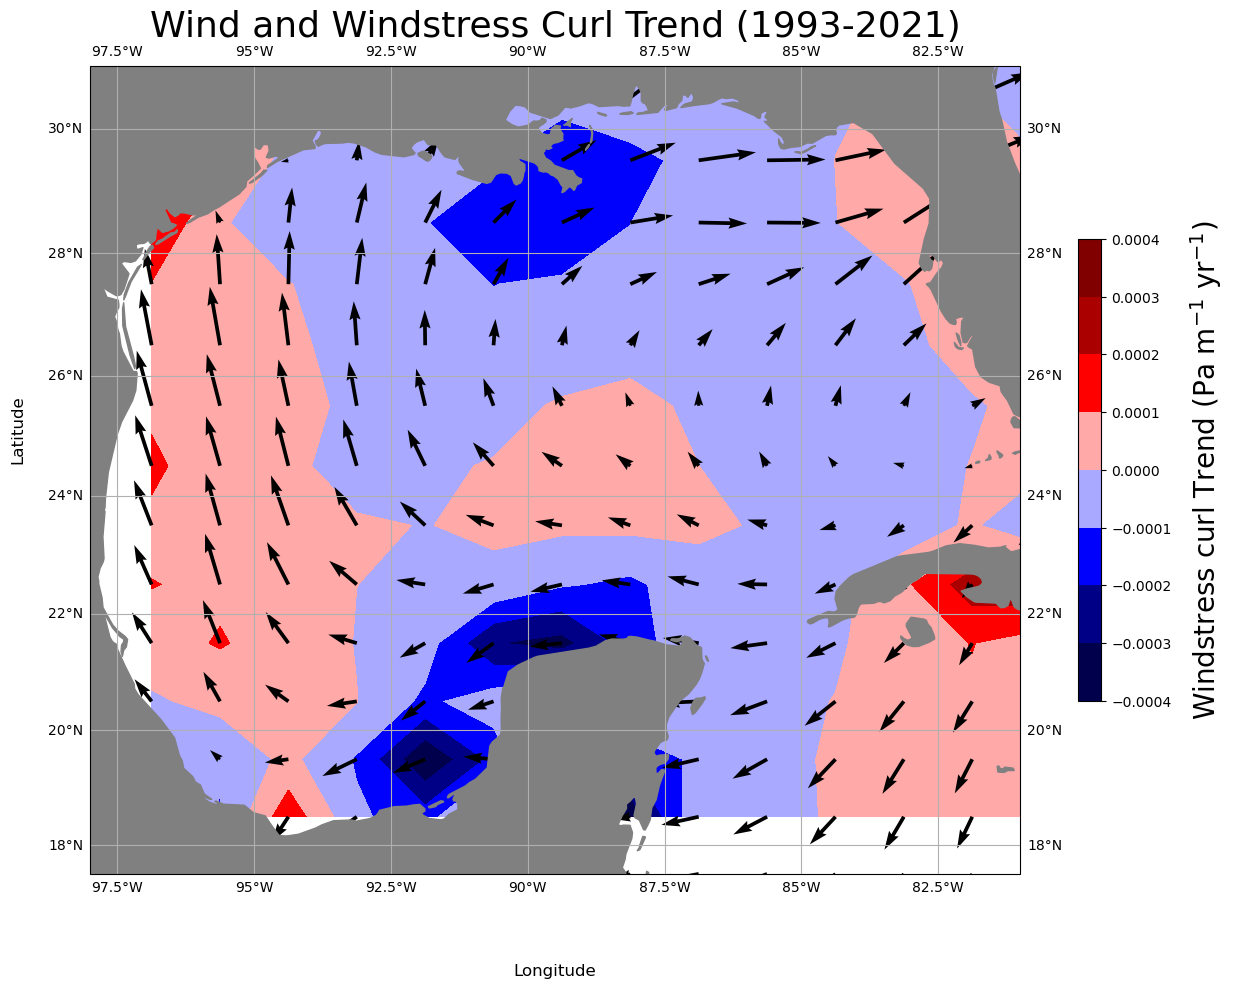

In [58]:
#positive windstress curl is upwelling
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
U = trend_ds.uas_polyfit_coefficients[0]
V = trend_ds.vas_polyfit_coefficients[0]
#C = ds.wsc.mean('time')
cf = ax.contourf(ds.lon, ds.lat, trend_ds.wsc_polyfit_coefficients[0], cmap='seismic', 
                 vmin=-3e-4, vcenter=0, vmax=3e-4, transform=ccrs.PlateCarree())
im = ax.quiver(ds.lon, ds.lat,
               U.values, 
               V.values,
               color='k', width=0.004, transform=ccrs.PlateCarree())#, 'green', 'red']))#, vmin=34, vmax=35)
cb = fig.colorbar(cf, ax=ax, shrink=0.4)
cb.set_label(r"Windstress curl Trend (Pa m$^{-1}$ yr$^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Wind and Windstress Curl Trend (1993-2021)', fontsize=26);
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/ESM4/atm/trend_spatio_wsc-over-winds.pdf');

## Trends (basin-average)

#### Calculate trend lines

In [47]:
def trending(da, da_name):
    d = {}
    d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['lat', 'lon']))#.fillna(0.))
    d[f'{da_name}_trend_line_lr'] = (d[f'{da_name}_trend_lr'][0]*np.arange(0,da.time.size) 
                                     + d[f'{da_name}_trend_lr'][1])

    return d

In [48]:
trend_dict = [trending(ds[f'{i}'], i) for i in list(ds.data_vars)]

In [72]:
len(trend_dict)

12

In [69]:
print('Index to help navigate dicitonary list')
for (i,j) in zip(np.arange(0,12), list(ds.data_vars)):
    print(i, j)

Index to help navigate dicitonary list
0 clt
1 hfls
2 hfss
3 huss
4 tas
5 tauu
6 tauv
7 uas
8 vas
9 rls
10 rss
11 wsc


In [64]:
trend_dict[0]['clt_trend_line_lr']

array([nan, nan, nan, ..., nan, nan, nan])

In [65]:
trend_dict[0]['clt_trend_lr']

LinregressResult(slope=np.float64(nan), intercept=np.float64(nan), rvalue=np.float64(nan), pvalue=np.float64(nan), stderr=np.float64(nan), intercept_stderr=np.float64(nan))

In [67]:
trend_dict[1]['hfls_trend_line_lr']

array([nan, nan, nan, ..., nan, nan, nan])

In [68]:
trend_dict[1]['hfls_trend_lr']

LinregressResult(slope=np.float64(nan), intercept=np.float64(nan), rvalue=np.float64(nan), pvalue=np.float64(nan), stderr=np.float64(nan), intercept_stderr=np.float64(nan))

In [73]:
def plotting_trend_lines(da, trend_da, ylabel=None, var_title=None,):
    da.mean(['lat', 'lon']).plot(figsize=(15,4), color='blue')
    plt.plot(da.time, trend_da, color='r', linestyle='dashed')
    plt.grid()
    plt.ylabel(ylabel)
    plt.xlim(da.time.sel(time='1993-01-01', method='nearest'), 
             da.time.sel(time='2021-06-30', method='nearest'))
    plt.title(fr'ESM4 spatially averaged {var_title} (1993-2021)')
    #plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/trend_lines_{var_title}.pdf');

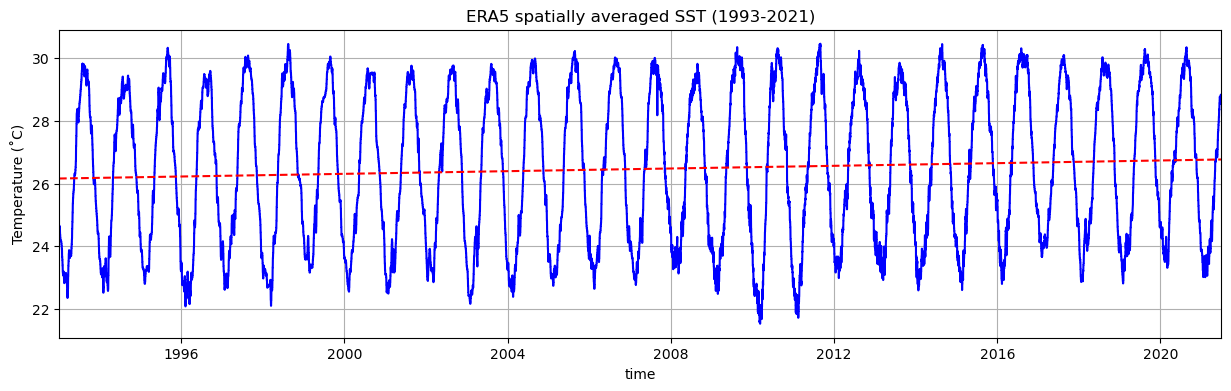

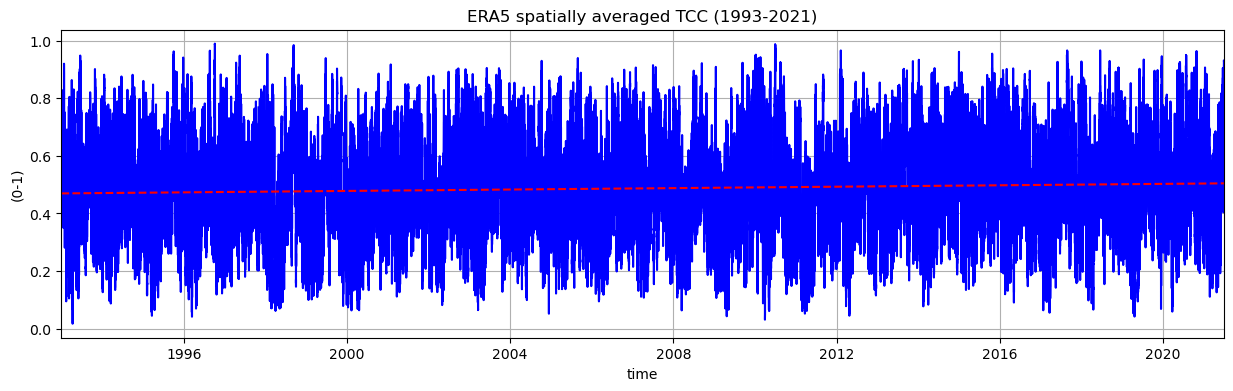

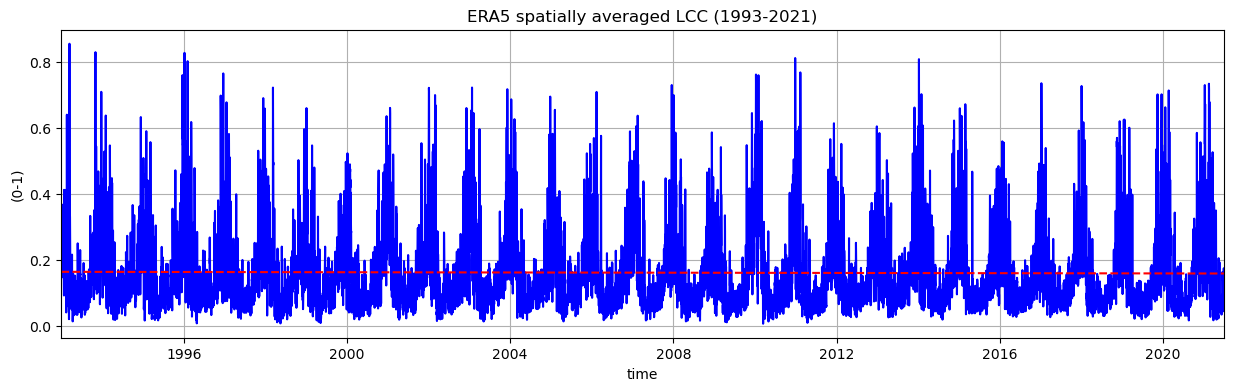

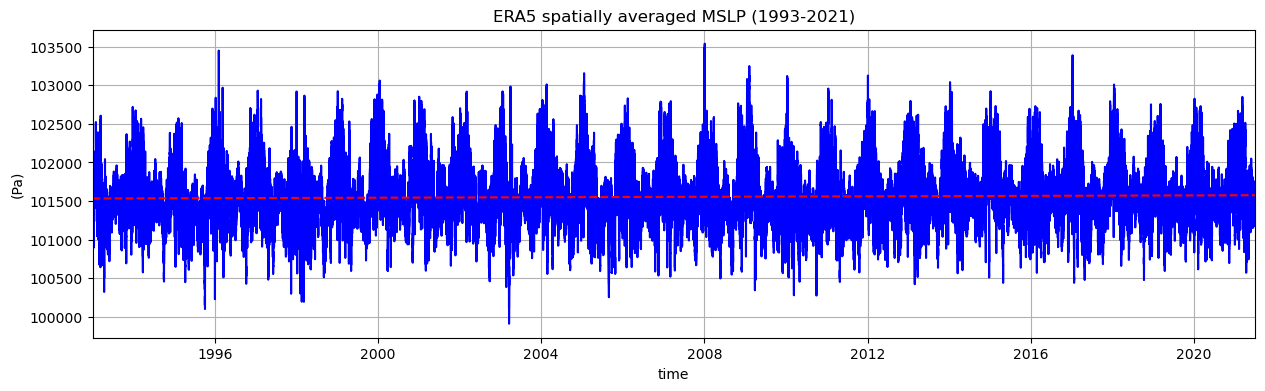

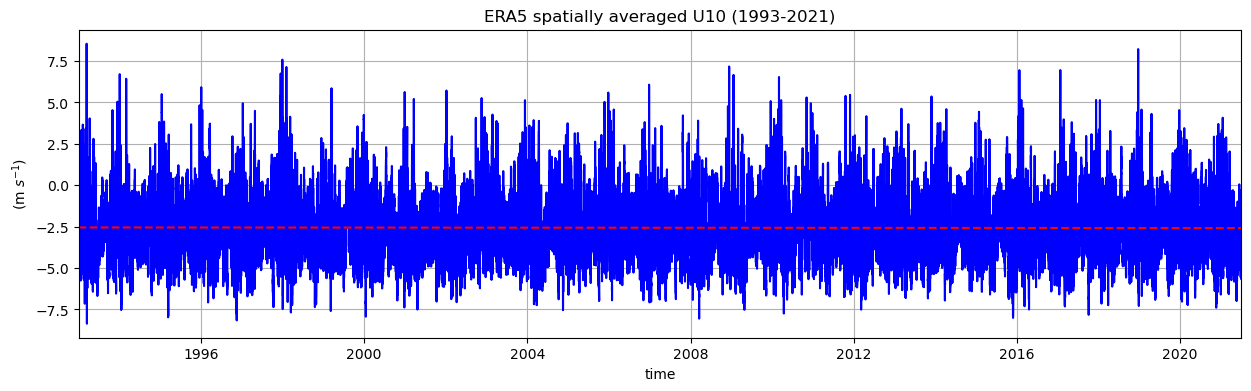

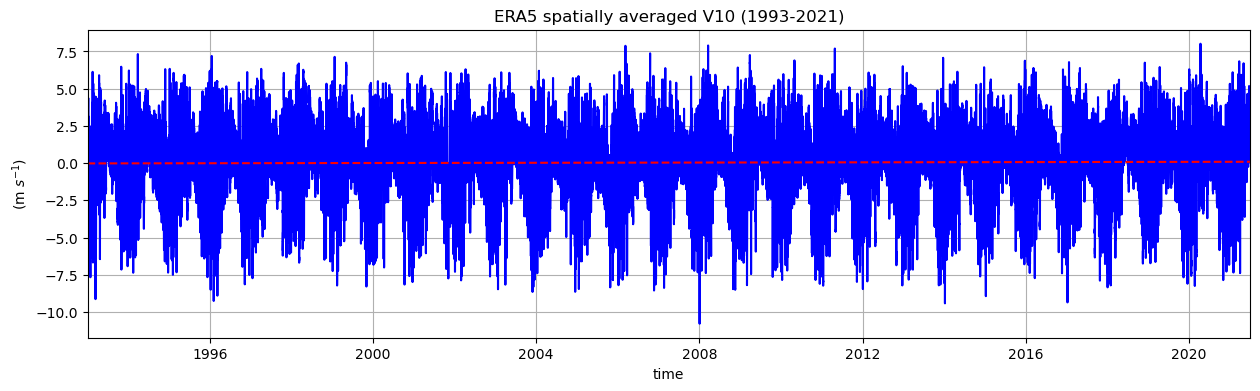

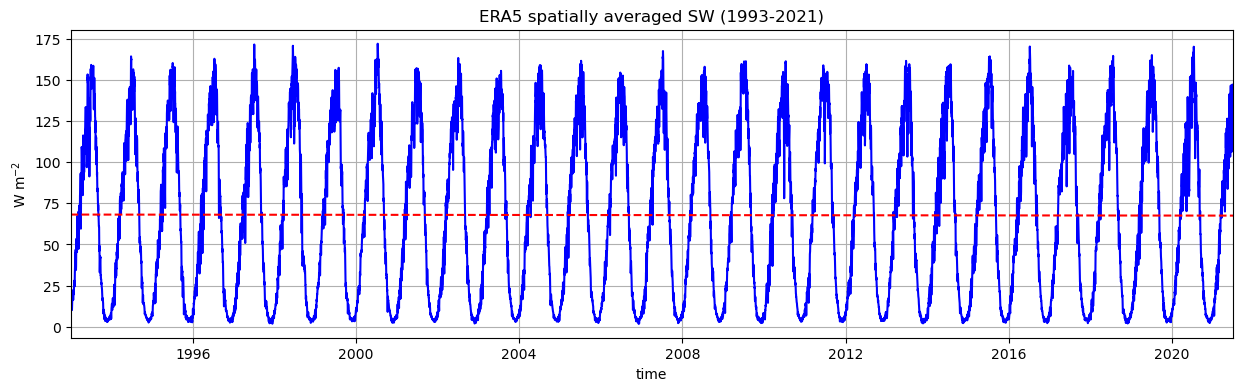

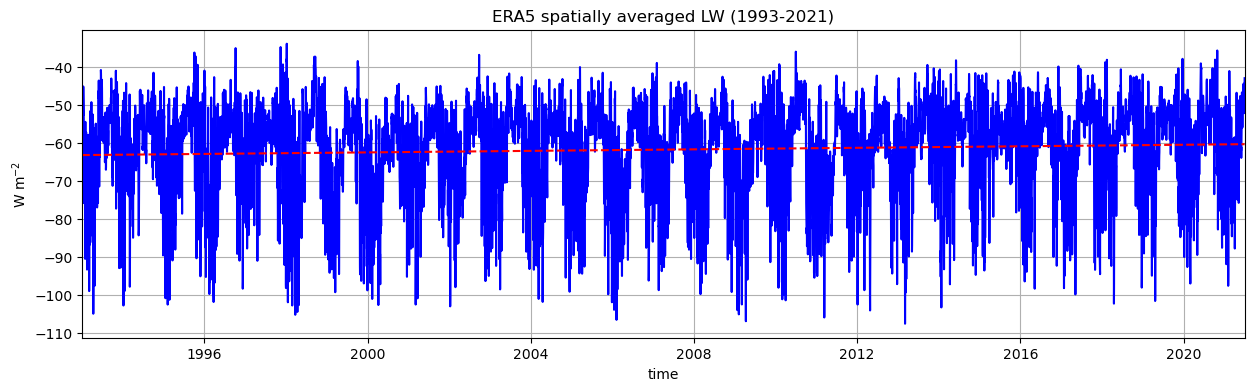

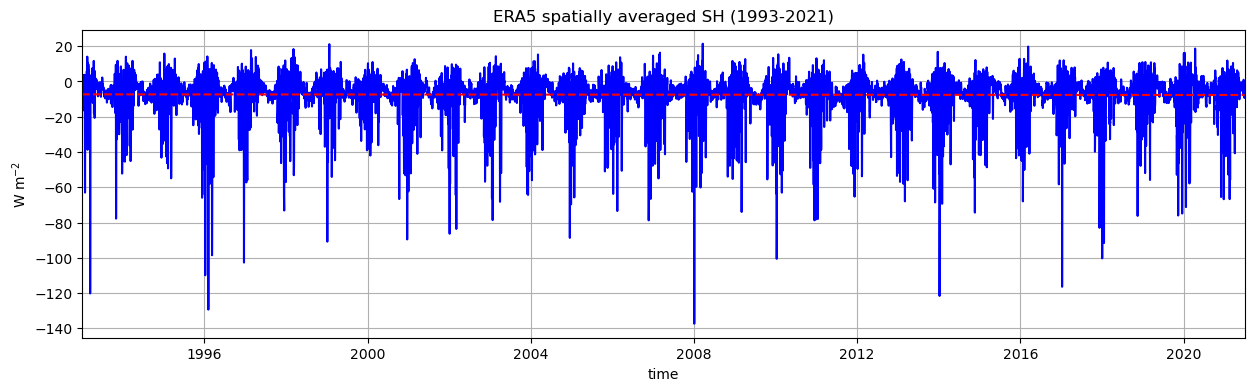

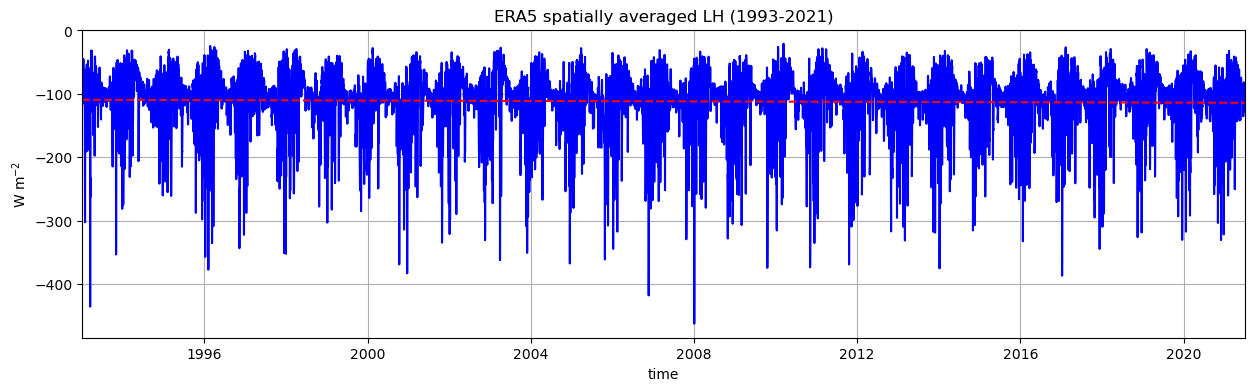

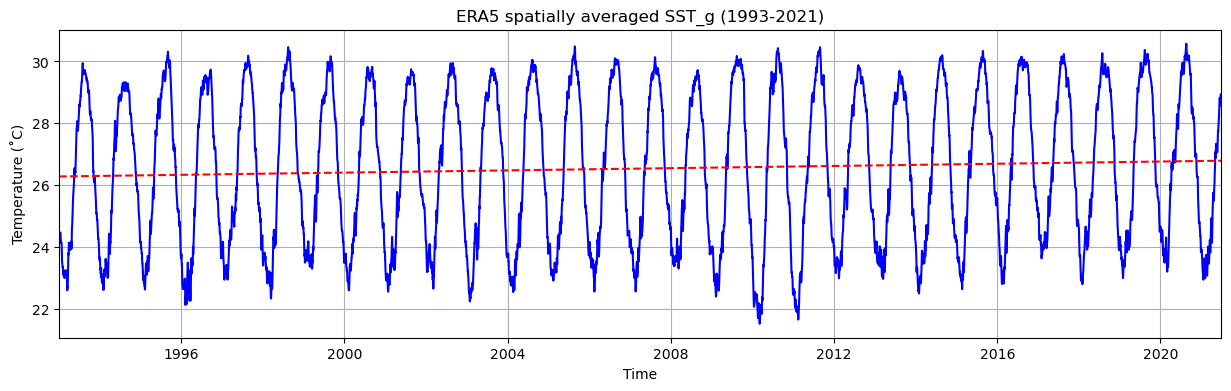

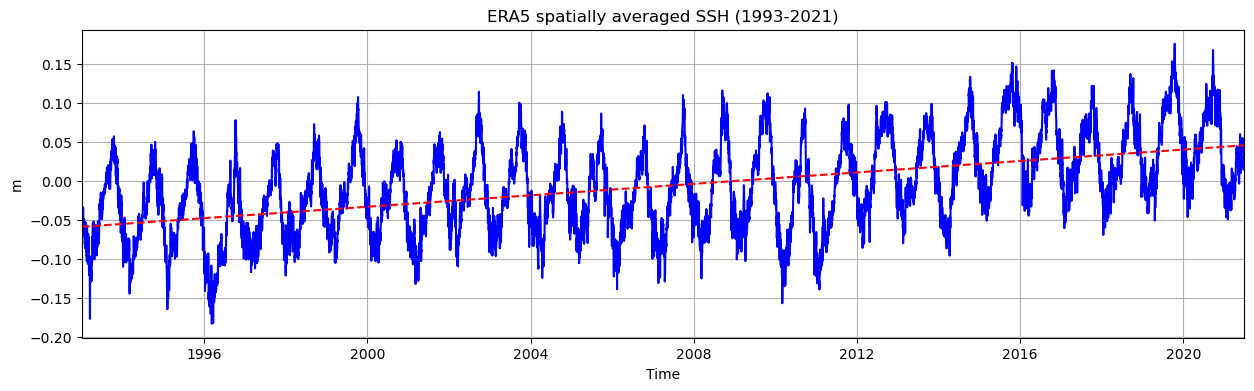

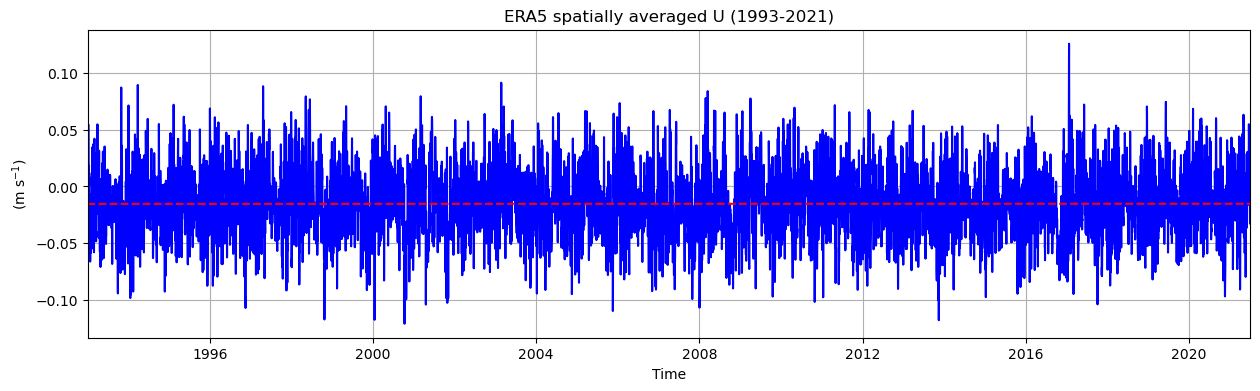

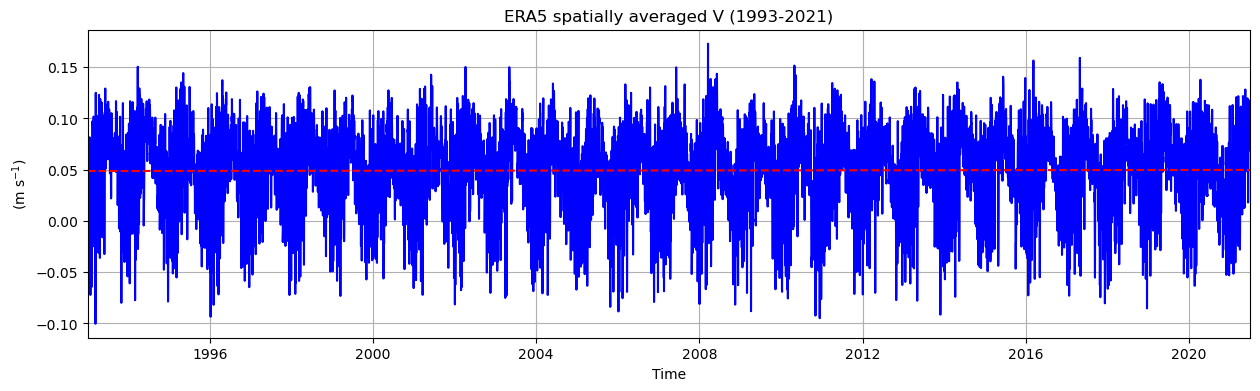

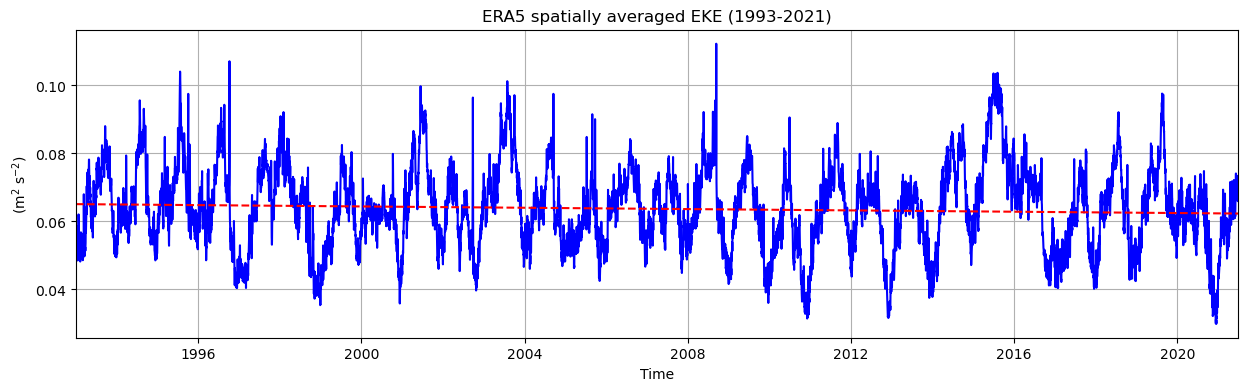

In [15]:
ylabels = ['Temperature (˚C)', '(0-1)', '(0-1)', '(Pa)', '(m $s^{-1}$)', '(m $s^{-1}$)',
           'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'Temperature (˚C)', 'm',
           '(m s$^{-1}$)', '(m s$^{-1}$)', '(m$^2$ s$^{-2}$)',]
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH', 'SST_g', 'SSH', 'U', 'V', 'EKE']
for (i,j,k,l) in zip(da_names, np.arange(0,15), ylabels, var_titles):
    plotting_trend_lines(i, trend_list[j]['trend_line_lr'], k, l)

In [16]:
for i in np.arange(0,15):
    print(var_titles[i], 'slope ==', trend_list[i]['trend_lr'][0])

SST slope == 2.4300805680235704e-06
TCC slope == 1.3989916844970575e-07
LCC slope == -4.938460552953631e-07
MSLP slope == 0.0001706701654631276
U10 slope == -1.4776785004170133e-07
V10 slope == 4.401516818593187e-07
SW slope == -6.121409525188441e-05
LW slope == 0.0002753859479434253
SH slope == -3.4988257570768775e-05
LH slope == -0.0004521648328423791
SST_g slope == 4.893266328504842e-05
SSH slope == 1.0044641534809106e-05
U slope == 1.3465207947274719e-08
V slope == 1.0190260243027439e-07
EKE slope == -2.6572447562337703e-07


In [20]:
trend_list[0]['trend_lr'][0]

np.float64(2.4300805680235704e-06)

In [17]:
trend_list[-5]['trend_lr'][0]

np.float64(4.893266328504842e-05)

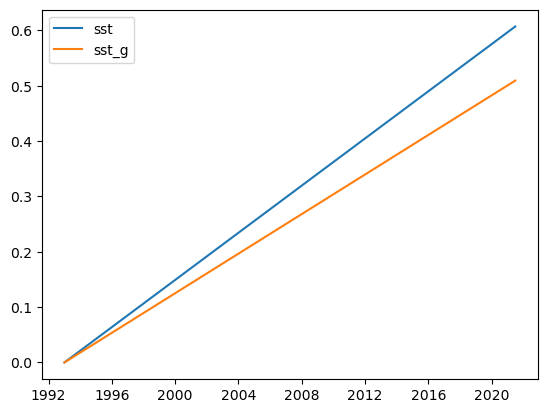

In [19]:
plt.plot(sst.time, trend_list[0]['trend_lr'][0]*np.arange(0,len(sst.time)), label='sst')
plt.plot(sst_g.time, trend_list[-5]['trend_lr'][0]*np.arange(0,len(sst_g.time)), label='sst_g')
plt.legend()

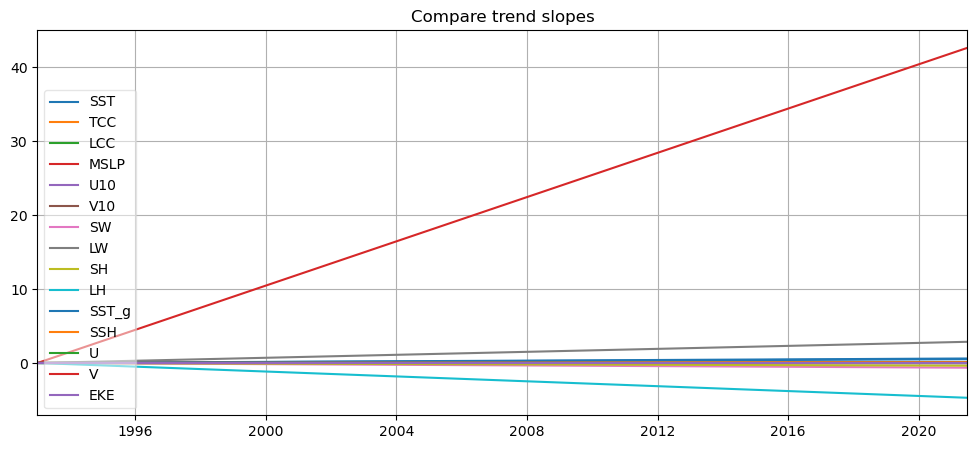

In [70]:
da_names = [sst, tcc, lcc, mslp, u10, v10, sw, lw, sh, lh, sst_g, ssh, u, v, eke] #[0:13]
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH', 'SST_g', 'SSH', 'U', 'V', 'EKE']
plt.figure(figsize=(12,5))
for i in np.arange(0,15):
    plt.plot(da_names[i].time, trend_list[i]['trend_lr'][0]*np.arange(0,len(da_names[i].time)), label=f'{var_titles[i]}')
plt.xlim(sst.time.sel(time='1993-01-01', method='nearest'), 
         sst.time.sel(time='2021-06-30', method='nearest'))
plt.legend()
plt.legend(loc='lower left', framealpha=0.5)
plt.grid()
plt.title('Compare trend slopes')
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/compare_trend_slopes.pdf')

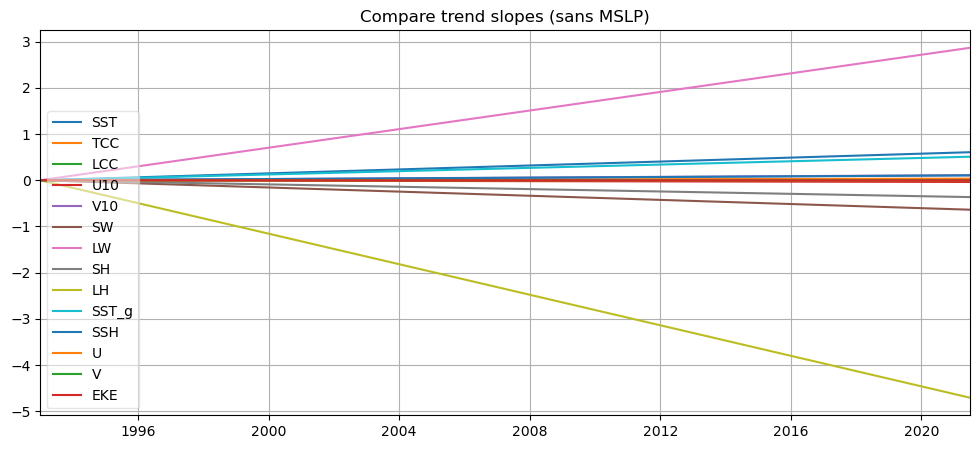

In [17]:
da_names = [sst, tcc, lcc, mslp, u10, v10, sw, lw, sh, lh, sst_g, ssh, u, v, eke] #[0:13]
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH', 'SST_g', 'SSH', 'U', 'V', 'EKE']
plt.figure(figsize=(12,5))
for i in np.arange(0,15):
    if i == 3:
        continue  
    plt.plot(da_names[i].time, trend_list[i]['trend_lr'][0]*np.arange(0,len(da_names[i].time)), label=f'{var_titles[i]}')
plt.xlim(sst.time.sel(time='1993-01-01', method='nearest'), 
         sst.time.sel(time='2021-06-30', method='nearest'))
plt.legend(loc='lower left', framealpha=0.5)
plt.grid()
plt.title('Compare trend slopes (sans MSLP)')
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/compare_trend_slopes_noMSLP.pdf')

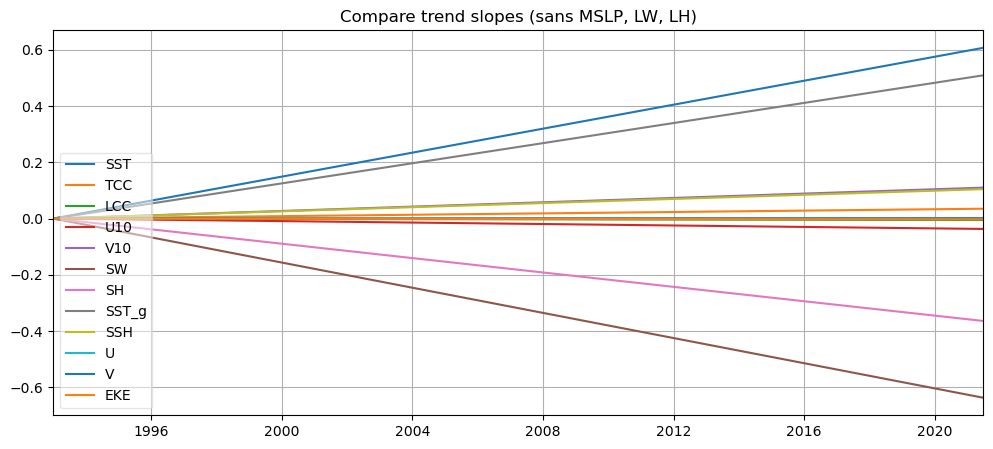

In [18]:
da_names = [sst, tcc, lcc, mslp, u10, v10, sw, lw, sh, lh, sst_g, ssh, u, v, eke] #[0:13]
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH', 'SST_g', 'SSH', 'U', 'V', 'EKE']
plt.figure(figsize=(12,5))
for i in np.arange(0,15):
    if i in [3, 7, 9]:
        continue  
    plt.plot(da_names[i].time, trend_list[i]['trend_lr'][0]*np.arange(0,len(da_names[i].time)), label=f'{var_titles[i]}')
plt.xlim(sst.time.sel(time='1993-01-01', method='nearest'), 
         sst.time.sel(time='2021-06-30', method='nearest'))
plt.legend(loc='lower left', framealpha=0.5)
plt.grid()
plt.title('Compare trend slopes (sans MSLP, LW, LH)')
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/compare_trend_slopes_noMSLP-LW-LH.pdf')

## EOF composites

### Load in data for EOFs

In [8]:
#ssh,eke,u,v,sst_g are from GLORYS

sst = xr.open_dataarray('/work5/stb/ERA5/anom-fields/sst_anom.nc', chunks={})
tcc = xr.open_dataarray('/work5/stb/ERA5/anom-fields/tcc_anom.nc', chunks={})
mslp = xr.open_dataarray('/work5/stb/ERA5/anom-fields/mslp_anom.nc', chunks={})
u10 = xr.open_dataarray('/work5/stb/ERA5/anom-fields/u10_anom.nc', chunks={})
v10 = xr.open_dataarray('/work5/stb/ERA5/anom-fields/v10_anom.nc', chunks={})
mask = xr.open_dataarray('/work5/stb/ERA5/mask.nc', chunks={})
lcc = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/lcc_anom.nc', chunks={})

sw = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/sw_anom.nc', chunks={})
lw = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/lw_anom.nc', chunks={})
sh = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/sh_anom.nc', chunks={})
lh = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/lh_anom.nc', chunks={})

ssh = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/ssh_anom.nc', chunks={})
u = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/u_anom.nc', chunks={})
v = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/v_anom.nc', chunks={})
eke = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/eke_anom.nc', chunks={})
sst_g = xr.open_dataarray('/work/Shanice.Bailey/ERA5/anom-fields/sst_g_anom.nc', chunks={})

In [9]:
def open_ds(filename):
    ds = xr.open_mfdataset(f'/work5/stb/MHW-gfdl/eofs/anom/{filename}_anom_*_9321.nc', chunks={})
    return ds

In [10]:
sst_eof = open_ds('sst')
tcc_eof = open_ds('tcc')
mslp_eof = open_ds('mslp')
u10_eof = open_ds('u10')
v10_eof = open_ds('v10')
lcc_eof = open_ds('lcc')

sw_eof = open_ds('sw')
lw_eof = open_ds('lw')
sh_eof = open_ds('sh')
lh_eof = open_ds('lh')

sst_g_eof = open_ds('sst_g')
ssh_eof = open_ds('ssh')
u_eof = open_ds('u')
v_eof = open_ds('v')
eke_eof = open_ds('eke')

## Calculate regression and plot

### Q FOR JOE: my data arrays are already nomalous (`b` in the regression func), do I still need `b = da_b - ...`

In [5]:
def regression(da_a, da_b, dims='time', source='era'):
    """Code borrowed from Joe Clark"""
    a = (da_a - da_a.mean(dim=dims)) / da_a.std()
    #a = (sst_eof.scores[mode] - sst_eof.scores[mode].mean(dim=dims)) / sst_eof.scores[mode].std()
    b = da_b - da_b.mean(dim=dims)#arrays are already anom so no need for this line

    if source=='era':
        C = (a.where(mask==0) * b.where(mask==0)).sum(dim=dims) / (a.where(mask==0)**2).sum(dim=dims)
    else:
        C = (a.where(mask==0) * b.where(~mask_g)).sum(dim=dims) / (a.where(mask==0)**2).sum(dim=dims)
    return C

/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/hom

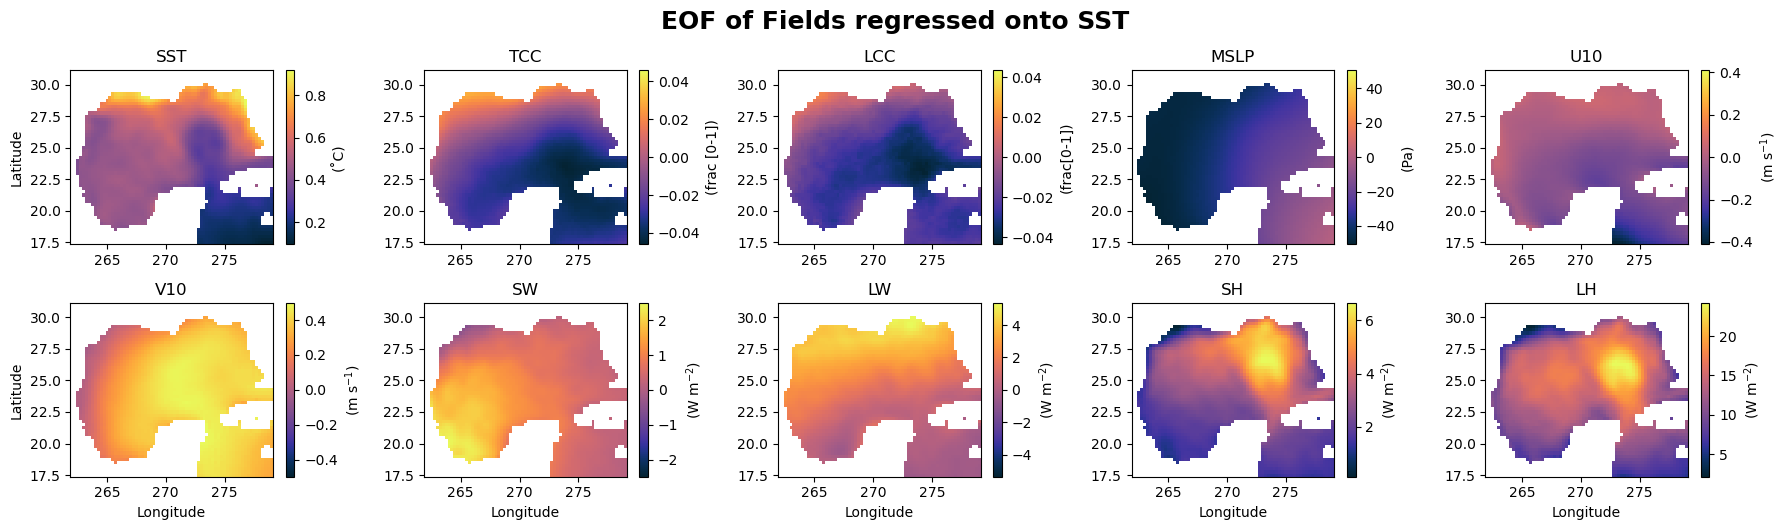

In [6]:
#regression of ERA5 fields on era5 sst_eof

#fields = [tcc_eof, lcc_eof, mslp_eof, u10_eof, v10_eof, sw_eof, lw_eof, 
#          sh_eof, lh_eof, ssh_eof, u_eof, v_eof, eke_eof]
fields = [sst, tcc, lcc, mslp, u10, v10, sw, lw, sh, lh]
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH']
units = ['(˚C)', '(frac [0-1])', '(frac[0-1])', '(Pa)', r'(m s$^{-1}$)', r'(m s$^{-1}$)',
         r'(W m$^{-2}$)', r'(W m$^{-2}$)', r'(W m$^{-2}$)', r'(W m$^{-2}$)']

fig, ax = plt.subplots(2,5, figsize=(18,5))
ax = ax.ravel()
for (i,j,k) in zip(fields, np.arange(0, len(fields)+1), units):
    #cmap_mask = plt.get_cmap("Greys")
    #mask.plot(cmap=cmap_mask, add_colorbar=False, ax=ax[j])
    regression(da_a = sst_eof.scores[0], 
               da_b = i, 
               dims='time').plot(cmap = cmocean.cm.thermal, ax=ax[j], cbar_kwargs={'label':k})
    ax[j].set_title(f'{var_titles[j]}')
ax[0].set_ylabel('Latitude')
ax[5].set_ylabel('Latitude')
for i in np.arange(1,10):
    if i == 5:
        continue
    ax[i].set_ylabel('')
[ax[i].set_xlabel('') for i in np.arange(0,5)]
[ax[i].set_xlabel('Longitude') for i in np.arange(5,10)]
plt.tight_layout()
st = plt.suptitle('EOF of Fields regressed onto SST', fontsize=18, fontweight='bold', y=1.05)
#plt.savefig('/work5/stb/MHW-gfdl/paper-figs/eof_regres.pdf', bbox_inches='tight', bbox_extra_artists=[st])

In [7]:
sst_eof

<xarray.Dataset> Size: 508kB
Dimensions:                   (latitude: 55, longitude: 69, mode: 3, time: 10408)
Coordinates:
  * latitude                  (latitude) float32 220B 17.5 17.75 ... 30.75 31.0
  * longitude                 (longitude) float32 276B 262.0 262.2 ... 279.0
  * mode                      (mode) int64 24B 1 2 3
    dayofyear                 (time) int64 83kB dask.array<chunksize=(10408,), meta=np.ndarray>
  * time                      (time) datetime64[ns] 83kB 1993-01-01 ... 2021-...
Data variables:
    components                (mode, latitude, longitude) float64 91kB dask.array<chunksize=(3, 55, 69), meta=np.ndarray>
    scores                    (mode, time) float64 250kB dask.array<chunksize=(3, 10408), meta=np.ndarray>
    explained_variance_ratio  (mode) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>

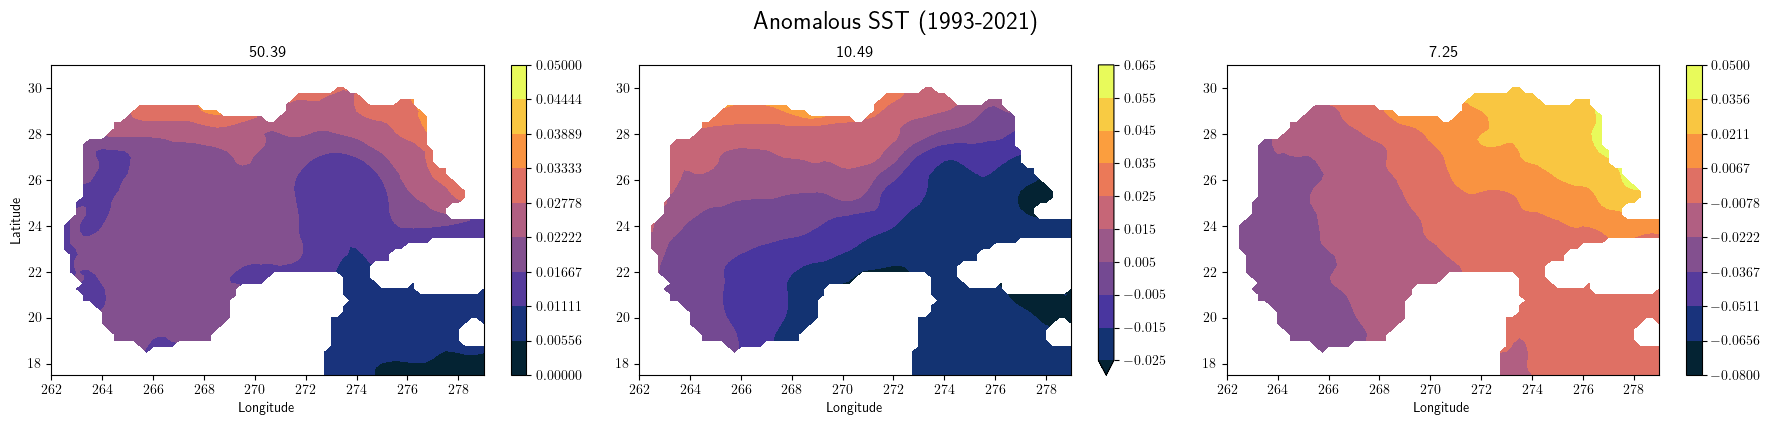

In [10]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_eof.components[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, 0.05, 10), 
                                                   cmap=cmocean.cm.thermal, cbar_kwargs={'label':''})
ax[0].set_title(f'{sst_eof.explained_variance_ratio[0].values*100:.2f} %')

sst_eof.components[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.025, .065, 10), 
                                                   cmap=cmocean.cm.thermal, cbar_kwargs={'label':''})
ax[1].set_title(f'{sst_eof.explained_variance_ratio[1].values*100:.2f} %')

sst_eof.components[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.08, .05, 10), 
                                                   cmap=cmocean.cm.thermal, cbar_kwargs={'label':''})
ax[2].set_title(f'{sst_eof.explained_variance_ratio[2].values*100:.2f} %')

ax[0].set_ylabel('Latitude')
[ax[i].set_ylabel('') for i in np.arange(1,3)]
[ax[i].set_xlabel('Longitude') for i in np.arange(0,3)]
plt.tight_layout()
st = plt.suptitle('Anomalous SST (1993-2021)', fontsize=18, fontweight='bold', y=1.05)
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/eof_sst.pdf', bbox_inches='tight', bbox_extra_artists=[st])